# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/CERNET-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'TST'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'TST_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'TST_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time        OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2013-02-19-22-10  3.897921e+06  3660.257162  2.038509e+06  54492.199769   
1  2013-02-19-22-15  3.714310e+06  4102.475155  2.010658e+06  44398.935617   
2  2013-02-19-22-20  3.824844e+06  3475.827556  2.022040e+06  39446.603085   
3  2013-02-19-22-25  3.967014e+06  3616.911661  2.005270e+06  42316.578675   
4  2013-02-19-22-30  3.708735e+06  3464.036062  2.017856e+06  44239.873981   

          OD_1-5         OD_1-6         OD_1-7         OD_1-8        OD_1-9  \
0  234230.295946   84819.101740  326551.951138   70567.750666  12520.192382   
1  200445.246659  118932.827733  345145.938997   73246.388000  13969.378085   
2  191539.466968  143379.788071  380456.462916   88085.648186  13683.572258   
3  171440.464195  139779.197759  399477.041689  100997.455279  13928.180880   
4  150425.682249  134512.997369  388659.765735   95906.154986  12303.793875   

   ...  OD_14-5  OD_14-6   OD_14-7      OD_14-8  OD_14-9      OD_14-10  \
0  ...      0.0      0.0  0.000000  1381.832533      0.0  10897.764534   
1  ...      0.0      0.0  0.000000  1123.647467      0.0  10333.189333   
2  ...      0.0      0.0  0.000000  1430.037600      0.0   9900.663200   
3  ...      0.0      0.0  0.000000  1954.184000      0.0  10663.956267   
4  ...      0.0      0.0  0.083324  3102.597333      0.0   7687.432800   

   OD_14-11      OD_14-12  OD_14-13  OD_14-14  
0       0.0  36048.613333       0.0       0.0  
1       0.0  32883.840000       0.0       0.0  
2       0.0  28923.253333       0.0       0.0  
3       0.0  34839.440000       0.0       0.0  
4       0.0  35943.493333       0.0       0.0  

[5 rows x 197 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
# data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
# df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2013-03-19 16:50:00', freq='5T')

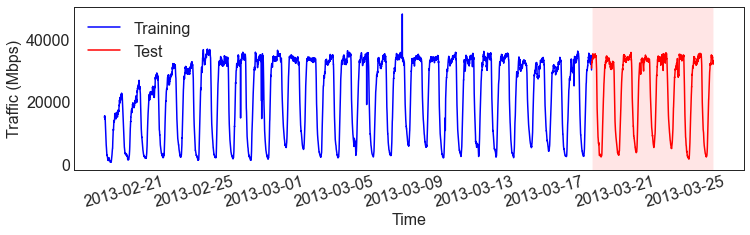

In [19]:
plt.figure(figsize=[12, 3])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
plt.xticks(rotation=15)
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

2.0845760812827483


In [26]:
print(np.min(data.flatten()))

-0.004873735825012876


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

9999


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(9989, 10, 196)

In [32]:
y_data.shape

(9989, 1, 196)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(9989, 196)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

7990

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6392

In [40]:
valid_length

1598

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6392, 196, 10)

In [43]:
y_train.shape

(6392, 196)

In [44]:
X_valid.shape

(1598, 196, 10)

In [45]:
y_valid.shape

(1598, 196)

In [46]:
X_test.shape

(1999, 196, 10)

In [47]:
y_test.shape

(1999, 196)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(7990, 196, 10)

In [50]:
y.shape

(7990, 196)

In [51]:
splits

((#6392) [0,1,2,3,4,5,6,7,8,9...],
 (#1598) [6392,6393,6394,6395,6396,6397,6398,6399,6400,6401...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#7990) [(TSTensor(vars:196, len:10), tensor([3.0473e-01, 4.0979e-03, 8.5294e-01, 3.2505e-01, 4.2390e-01, 1.7035e-01,
        2.3749e-01, 9.5876e-02, 6.0455e-02, 2.5291e-01, 2.3859e-01, 3.9024e-01,
        3.8565e-01, 5.5069e-01, 3.1508e-03, 0.0000e+00, 3.8347e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1409e-03, 0.0000e+00, 3.2674e-05,
        0.0000e+00, 1.0261e-03, 0.0000e+00, 0.0000e+00, 5.8814e-01, 3.1805e-05,
        3.6734e-02, 2.0680e-02, 1.1481e-01, 1.7415e-01, 1.7546e-01, 4.7027e-02,
        3.2714e-01, 3.2840e-01, 2.6392e-01, 2.5046e-01, 2.2083e-01, 8.3459e-01,
        8.6948e-02, 0.0000e+00, 3.6272e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3882e-04, 0.0000e+00, 6.2002e-02, 0.0000e+00, 4.5756e-02,
        0.0000e+00, 0.0000e+00, 4.2969e-01, 0.0000e+00, 1.5752e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6673e-02, 0.0000e+00, 1.0326e-01,
        0.0000e+00, 1.9820e-01, 0.0000e+00, 0.0000e+00, 1.3957e-01, 1.2948e-05,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "d_model": hp.choice('d_model', [64, 128, 256]),
    "n_heads": hp.choice('n_heads', [8, 16, 32])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1e64368e548>,
 'lr': <hyperopt.pyll.base.Apply at 0x1e64368ea88>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1e64368ec88>,
 'patience': <hyperopt.pyll.base.Apply at 0x1e64367bd48>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1e64367b088>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1e64367b048>,
 'd_model': <hyperopt.pyll.base.Apply at 0x1e64369d488>,
 'n_heads': <hyperopt.pyll.base.Apply at 0x1e64369dac8>}

In [55]:
# clear memory 
gc.collect()

71

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TST
        k = {
            'n_layers': params['n_layers'],
            'd_model': params['d_model'],
            'n_heads': params['n_heads']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 64, 'epochs': 100, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  0%|                                                                          | 0/100 [00:02<?, ?trial/s, best loss=?]

No improvement since epoch 14: early stopping                                                                          
  0%|                                                                          | 0/100 [00:24<?, ?trial/s, best loss=?]

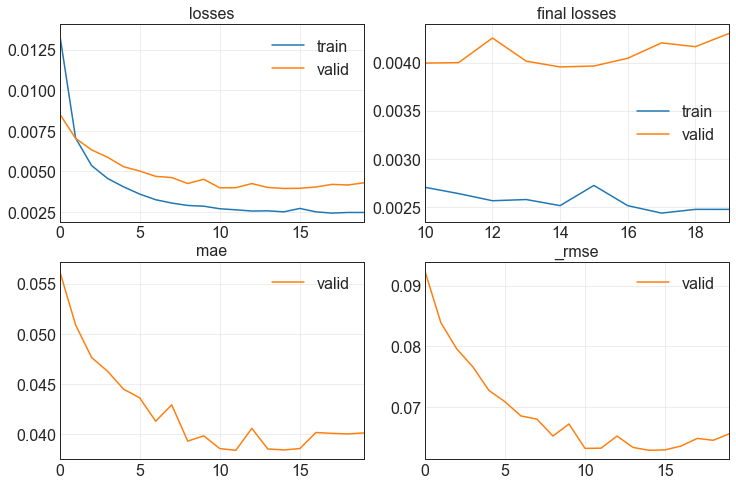

21.905025959014893                                                                                                     
[0.0024753210600465536, 0.0043029338121414185, 0.04009270668029785, 0.06559675186872482]                               
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  1%|▍                                            | 1/100 [00:25<40:47, 24.73s/trial, best loss: 0.0043029338121414185]

No improvement since epoch 45: early stopping                                                                          
  1%|▍                                            | 1/100 [01:12<40:47, 24.73s/trial, best loss: 0.0043029338121414185]

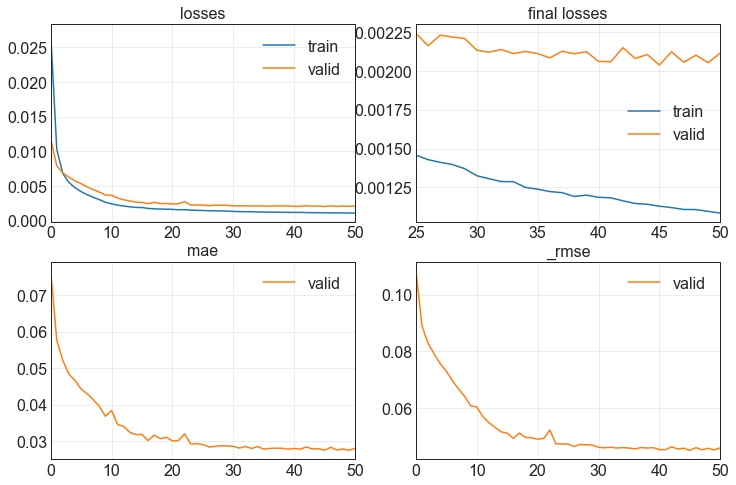

47.114365577697754                                                                                                     
[0.0010848300298675895, 0.0021142163313925266, 0.02798621915280819, 0.04598060995340347]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  2%|▉                                            | 2/100 [01:14<51:55, 31.79s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 3: early stopping                                                                           
  2%|▉                                            | 2/100 [02:12<51:55, 31.79s/trial, best loss: 0.0021142163313925266]

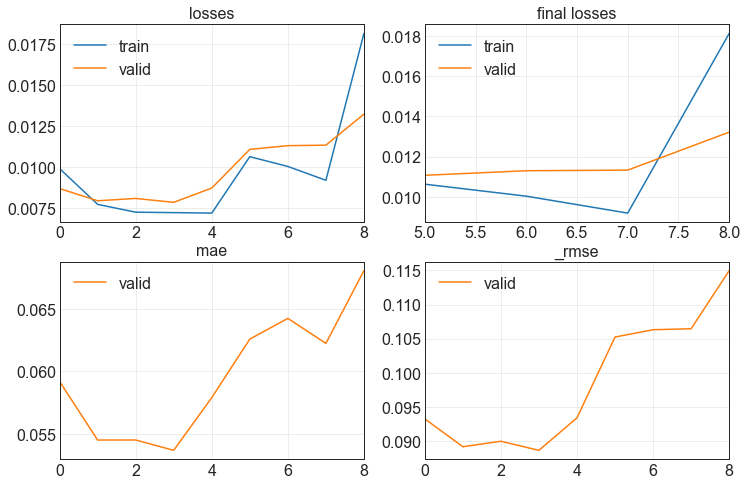

58.93866991996765                                                                                                      
[0.018127748742699623, 0.013220167718827724, 0.06807269155979156, 0.11497898399829865]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  3%|█▎                                         | 3/100 [02:14<1:05:07, 40.28s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 24: early stopping                                                                          
  3%|█▎                                         | 3/100 [06:55<1:05:07, 40.28s/trial, best loss: 0.0021142163313925266]

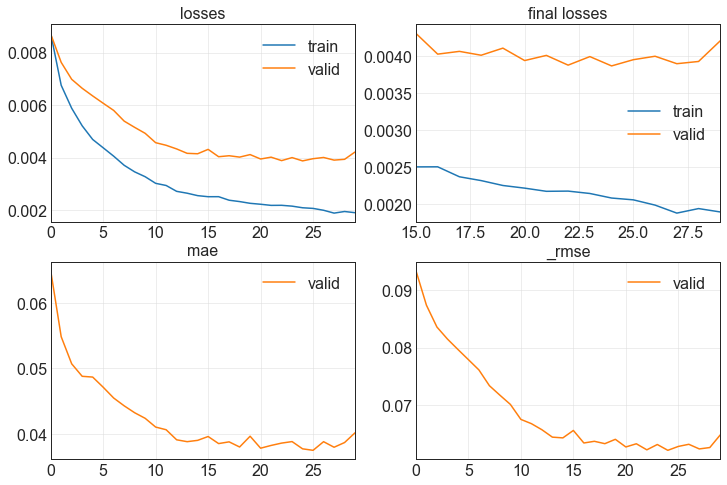

281.4661064147949                                                                                                      
[0.0018930590013042092, 0.004210757091641426, 0.040157251060009, 0.06489035487174988]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
  4%|█▋                                        | 4/100 [06:56<3:00:45, 112.97s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 20: early stopping                                                                          
  4%|█▋                                        | 4/100 [09:34<3:00:45, 112.97s/trial, best loss: 0.0021142163313925266]

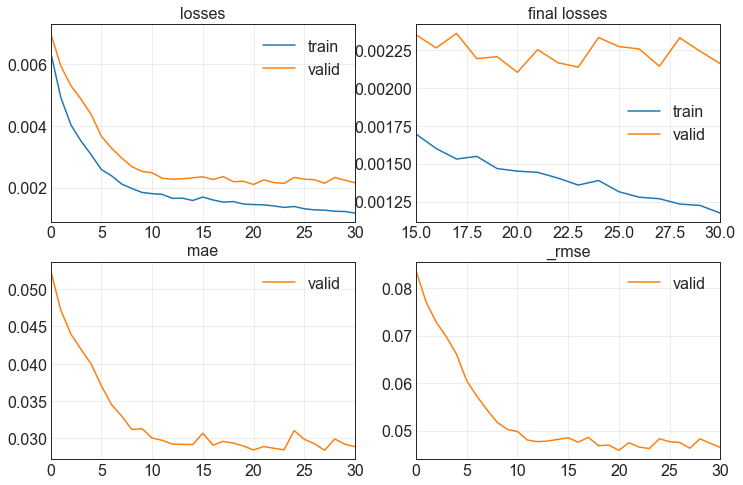

158.60512232780457                                                                                                     
[0.0011739438632503152, 0.0021590888500213623, 0.028904687613248825, 0.046466000378131866]                             
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  5%|██                                        | 5/100 [09:36<3:21:04, 127.00s/trial, best loss: 0.0021142163313925266]

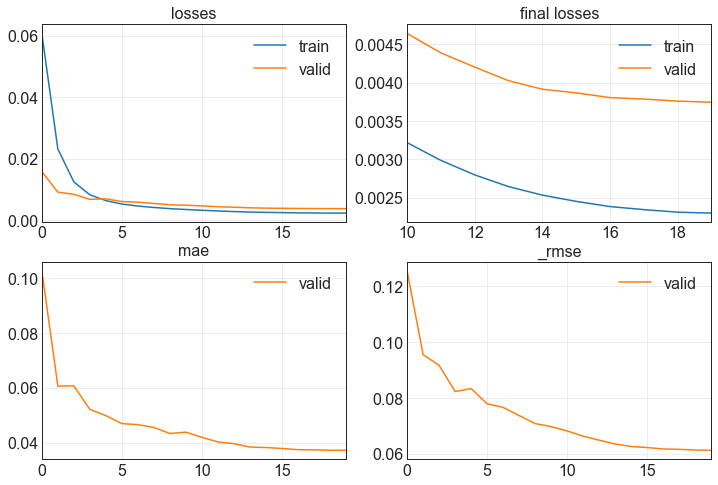

26.223026990890503                                                                                                     
[0.0022979688365012407, 0.0037445027846843004, 0.03717876598238945, 0.0611923411488533]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  6%|██▌                                        | 6/100 [10:03<2:32:08, 97.11s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 1: early stopping                                                                           
  6%|██▌                                        | 6/100 [10:57<2:32:08, 97.11s/trial, best loss: 0.0021142163313925266]

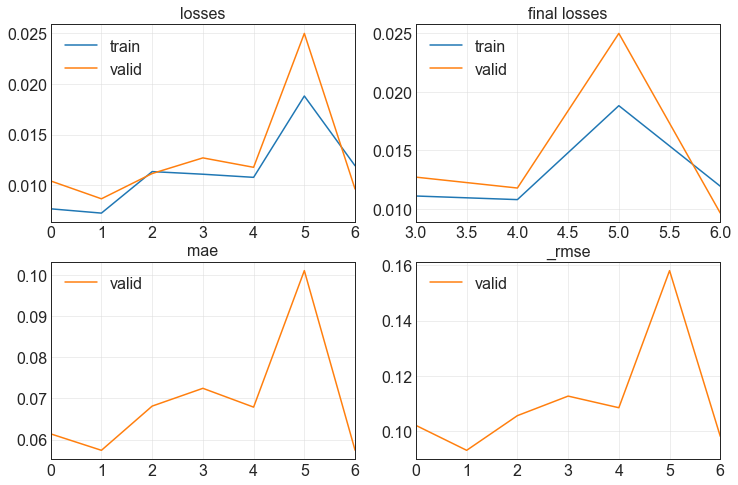

54.388936281204224                                                                                                     
[0.011939829215407372, 0.009647024795413017, 0.057401109486818314, 0.09821926057338715]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  7%|███                                        | 7/100 [10:59<2:11:10, 84.63s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 11: early stopping                                                                          
  7%|███                                        | 7/100 [11:20<2:11:10, 84.63s/trial, best loss: 0.0021142163313925266]

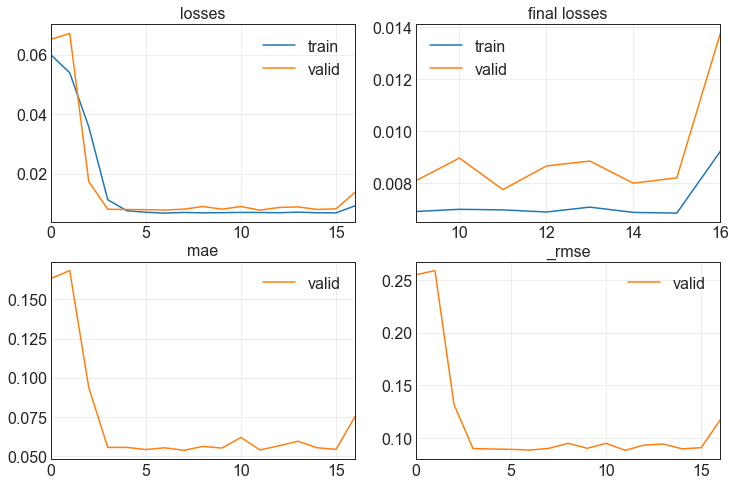

21.183860540390015                                                                                                     
[0.00922656524926424, 0.013749707490205765, 0.07523123174905777, 0.11725915223360062]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  8%|███▍                                       | 8/100 [11:21<1:41:05, 65.93s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 24: early stopping                                                                          
  8%|███▍                                       | 8/100 [13:47<1:41:05, 65.93s/trial, best loss: 0.0021142163313925266]

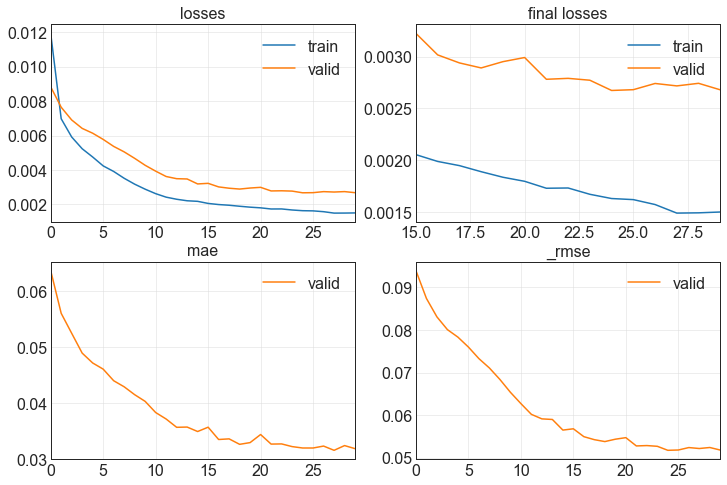

146.10910654067993                                                                                                     
[0.0015041830483824015, 0.002679473254829645, 0.03183364495635033, 0.051763635128736496]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 50, 'lr': 0.1, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
  9%|███▊                                       | 9/100 [13:48<2:16:59, 90.32s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 2: early stopping                                                                           
  9%|███▊                                       | 9/100 [14:15<2:16:59, 90.32s/trial, best loss: 0.0021142163313925266]

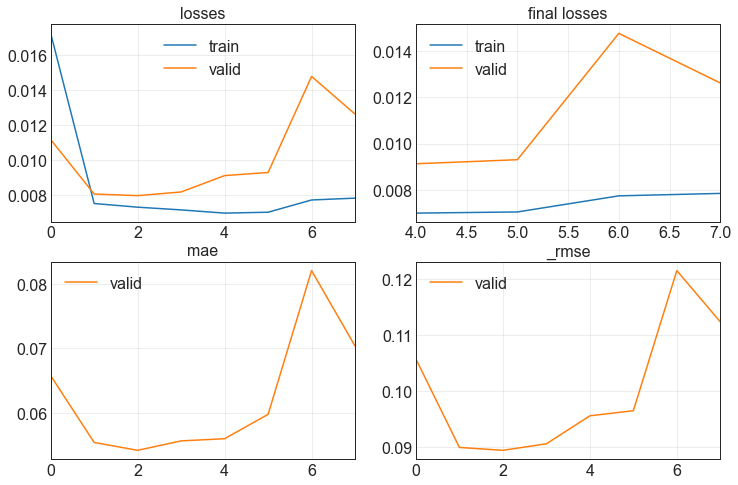

27.445183277130127                                                                                                     
[0.007844321429729462, 0.01262249518185854, 0.07037588208913803, 0.11234989017248154]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 10%|████▏                                     | 10/100 [14:17<1:47:41, 71.80s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 4: early stopping                                                                           
 10%|████▏                                     | 10/100 [15:07<1:47:41, 71.80s/trial, best loss: 0.0021142163313925266]

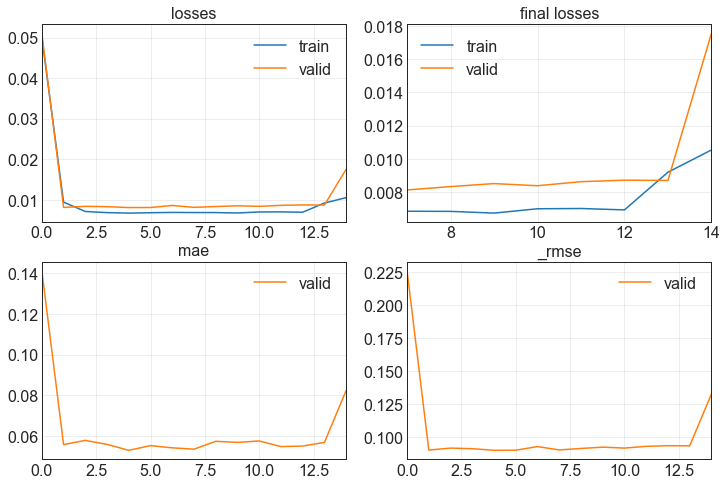

50.568021297454834                                                                                                     
[0.010540979914367199, 0.01754981279373169, 0.08251813054084778, 0.13247568905353546]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 11%|████▌                                     | 11/100 [15:09<1:37:36, 65.81s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 27: early stopping                                                                          
 11%|████▌                                     | 11/100 [17:00<1:37:36, 65.81s/trial, best loss: 0.0021142163313925266]

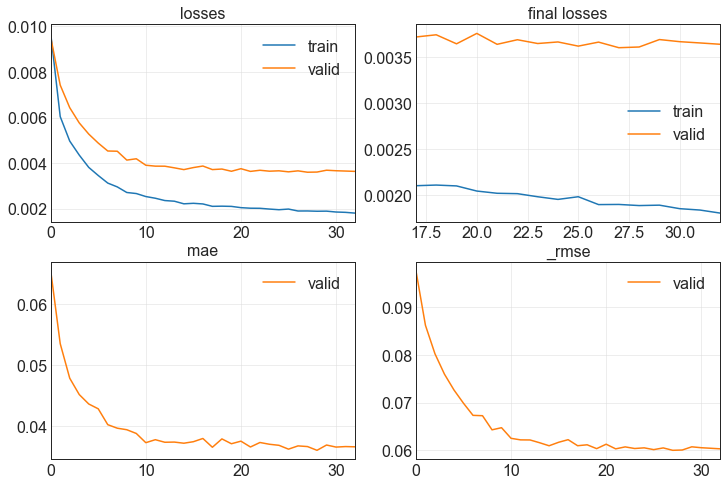

111.7110002040863                                                                                                      
[0.0018067563651129603, 0.0036375902127474546, 0.03666449710726738, 0.06031243875622749]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 12%|█████                                     | 12/100 [17:02<1:57:12, 79.91s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 9: early stopping                                                                           
 12%|█████                                     | 12/100 [17:36<1:57:12, 79.91s/trial, best loss: 0.0021142163313925266]

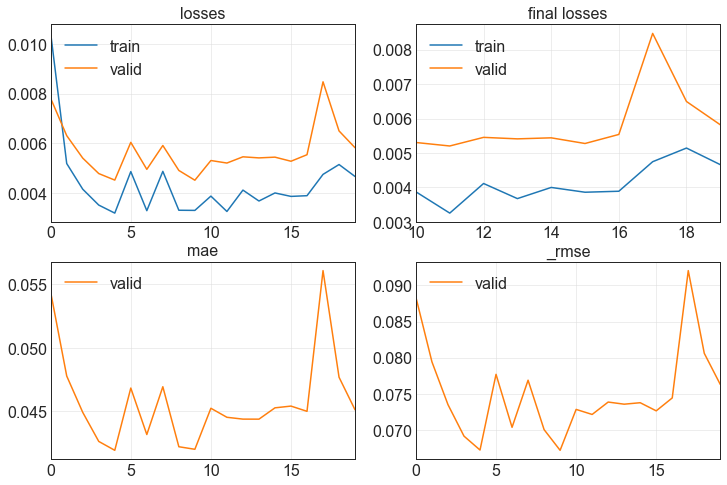

35.17700910568237                                                                                                      
[0.0046602776274085045, 0.005818677134811878, 0.045095112174749374, 0.07628025114536285]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 50, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 13%|█████▍                                    | 13/100 [17:38<1:36:54, 66.84s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 7: early stopping                                                                           
 13%|█████▍                                    | 13/100 [17:47<1:36:54, 66.84s/trial, best loss: 0.0021142163313925266]

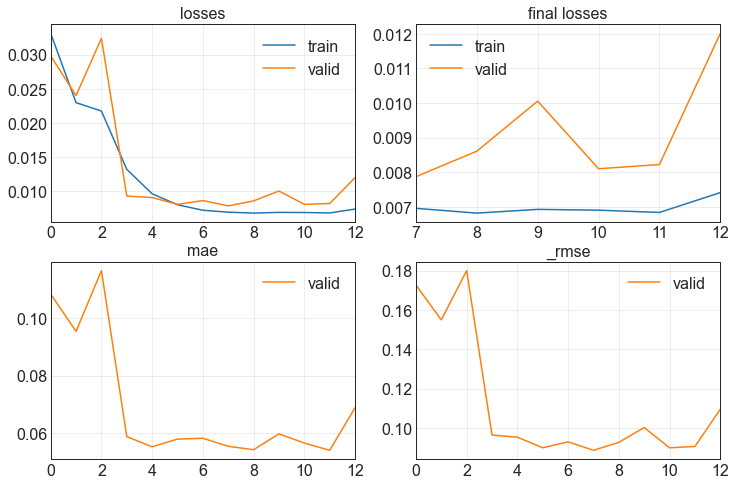

9.339949369430542                                                                                                      
[0.00741133838891983, 0.01201078575104475, 0.0688621774315834, 0.10959372669458389]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 14%|█████▉                                    | 14/100 [17:48<1:11:33, 49.92s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 13: early stopping                                                                          
 14%|█████▉                                    | 14/100 [19:43<1:11:33, 49.92s/trial, best loss: 0.0021142163313925266]

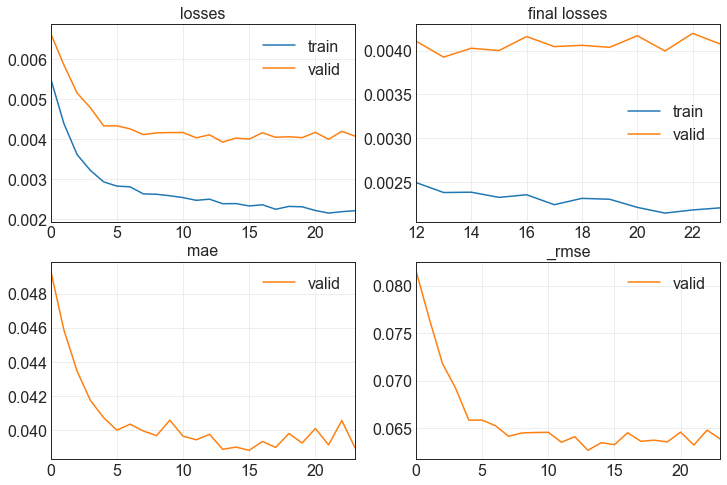

115.48709964752197                                                                                                     
[0.0022040267940610647, 0.004075511824339628, 0.038954976946115494, 0.06383974105119705]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 15%|██████▎                                   | 15/100 [19:45<1:39:03, 69.93s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 1: early stopping                                                                           
 15%|██████▎                                   | 15/100 [20:28<1:39:03, 69.93s/trial, best loss: 0.0021142163313925266]

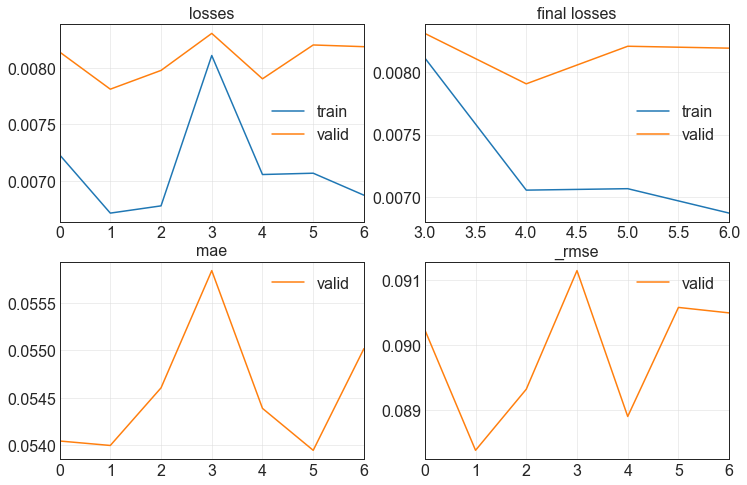

43.75092029571533                                                                                                      
[0.006873833015561104, 0.00818902999162674, 0.05501741170883179, 0.09049326181411743]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.1, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 16%|██████▋                                   | 16/100 [20:30<1:27:22, 62.41s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 2: early stopping                                                                           
 16%|██████▋                                   | 16/100 [20:56<1:27:22, 62.41s/trial, best loss: 0.0021142163313925266]

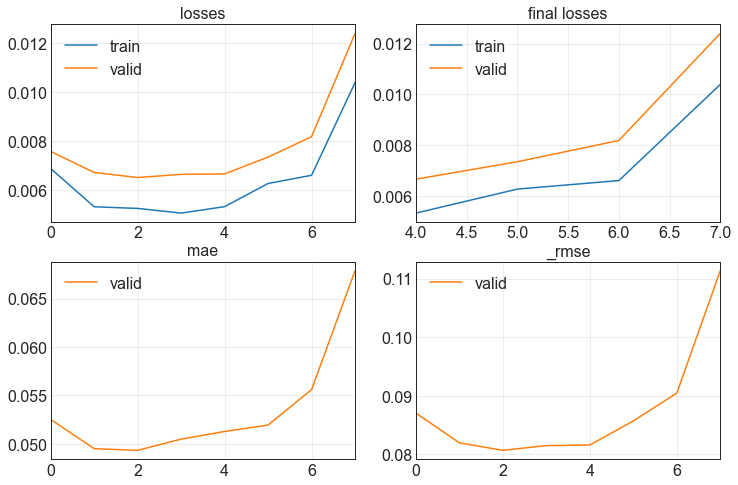

26.76758074760437                                                                                                      
[0.010394593700766563, 0.012406229972839355, 0.06789419800043106, 0.11138325929641724]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 17%|███████▏                                  | 17/100 [20:58<1:11:59, 52.04s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 3: early stopping                                                                           
 17%|███████▏                                  | 17/100 [21:20<1:11:59, 52.04s/trial, best loss: 0.0021142163313925266]

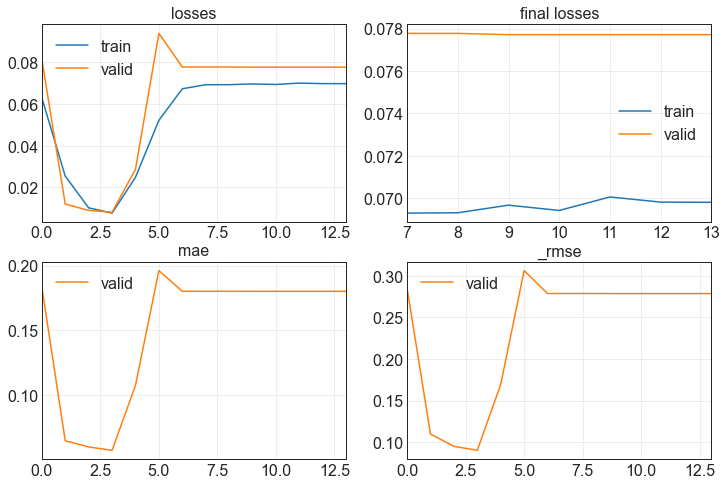

22.682459115982056                                                                                                     
[0.06980419903993607, 0.07771588116884232, 0.18017978966236115, 0.278775691986084]                                     
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 18%|███████▉                                    | 18/100 [21:22<59:32, 43.57s/trial, best loss: 0.0021142163313925266]

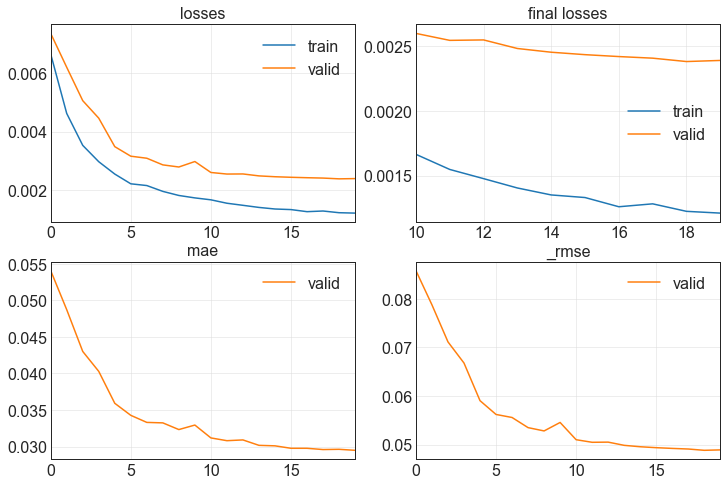

153.07035040855408                                                                                                     
[0.0012106061913073063, 0.0023919662926346064, 0.029488781467080116, 0.04890773445367813]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 19%|███████▉                                  | 19/100 [23:56<1:43:36, 76.75s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 0: early stopping                                                                           
 19%|███████▉                                  | 19/100 [25:21<1:43:36, 76.75s/trial, best loss: 0.0021142163313925266]

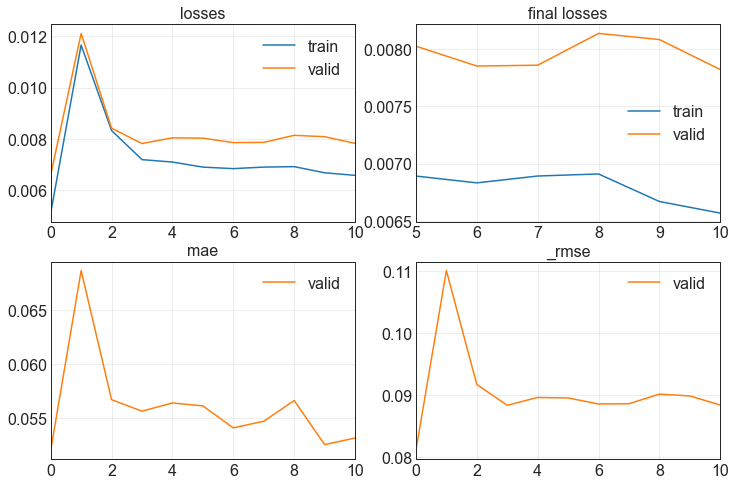

85.82302165031433                                                                                                      
[0.0065695736557245255, 0.007819287478923798, 0.05312718078494072, 0.08842673152685165]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 20%|████████▍                                 | 20/100 [25:23<1:46:24, 79.81s/trial, best loss: 0.0021142163313925266]

No improvement since epoch 40: early stopping                                                                          
 20%|████████▍                                 | 20/100 [26:25<1:46:24, 79.81s/trial, best loss: 0.0021142163313925266]

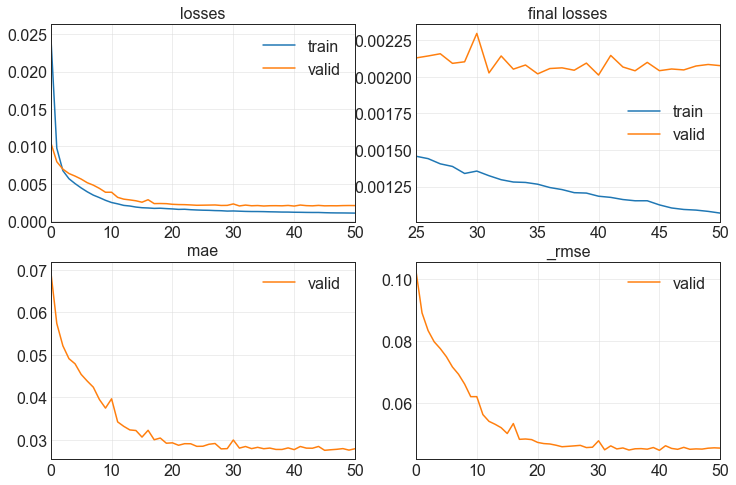

62.700053215026855                                                                                                     
[0.0010682155843824148, 0.00207673036493361, 0.02789357677102089, 0.04557115584611893]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 21%|█████████▏                                  | 21/100 [26:26<1:38:45, 75.01s/trial, best loss: 0.00207673036493361]

No improvement since epoch 41: early stopping                                                                          
 21%|█████████▏                                  | 21/100 [27:30<1:38:45, 75.01s/trial, best loss: 0.00207673036493361]

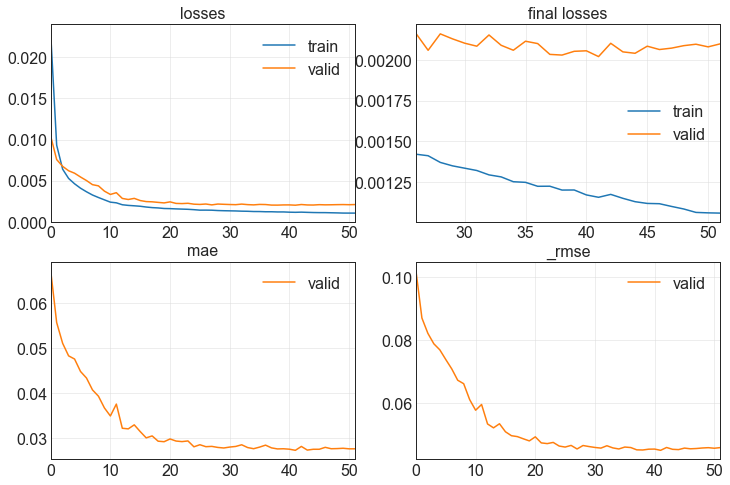

63.891897201538086                                                                                                     
[0.0010596958454698324, 0.0020992986392229795, 0.027666931971907616, 0.04581810534000397]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 22%|█████████▋                                  | 22/100 [27:31<1:33:36, 72.01s/trial, best loss: 0.00207673036493361]

No improvement since epoch 40: early stopping                                                                          
 22%|█████████▋                                  | 22/100 [28:34<1:33:36, 72.01s/trial, best loss: 0.00207673036493361]

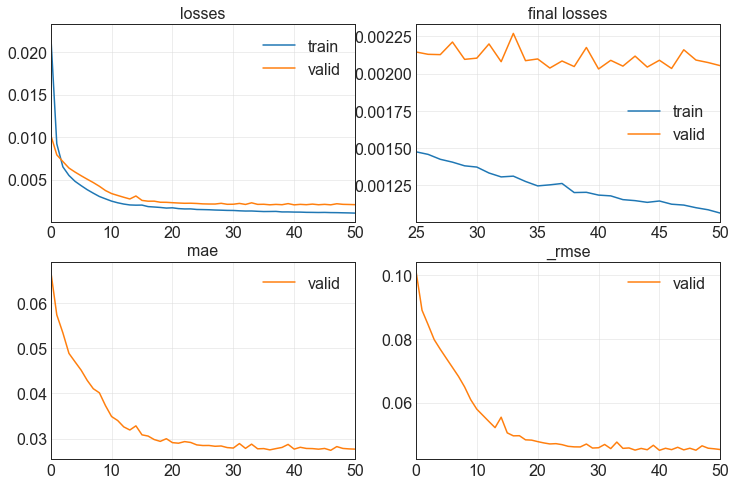

63.45030903816223                                                                                                      
[0.0010611078469082713, 0.002053575124591589, 0.02766288071870804, 0.045316386967897415]                               
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 23%|█████████▉                                 | 23/100 [28:36<1:29:32, 69.77s/trial, best loss: 0.002053575124591589]

No improvement since epoch 38: early stopping                                                                          
 23%|█████████▉                                 | 23/100 [29:38<1:29:32, 69.77s/trial, best loss: 0.002053575124591589]

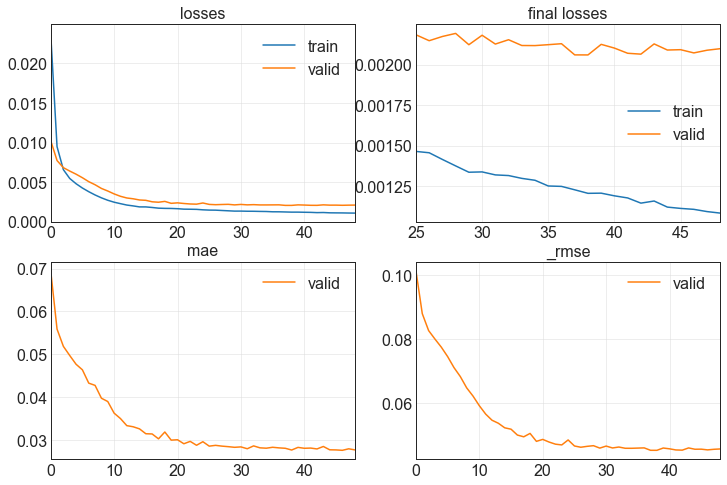

62.67129421234131                                                                                                      
[0.0010835053399205208, 0.00209769606590271, 0.02767833322286606, 0.04580061137676239]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 24%|██████████▎                                | 24/100 [29:40<1:26:07, 67.99s/trial, best loss: 0.002053575124591589]

No improvement since epoch 42: early stopping                                                                          
 24%|██████████▎                                | 24/100 [30:48<1:26:07, 67.99s/trial, best loss: 0.002053575124591589]

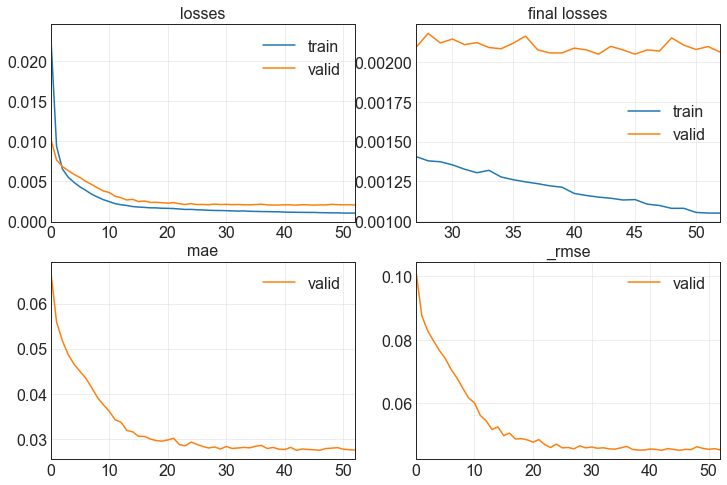

68.96606588363647                                                                                                      
[0.0010506701655685902, 0.0020625849720090628, 0.027552107349038124, 0.045415692031383514]                             
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 25%|██████████▊                                | 25/100 [30:50<1:25:47, 68.63s/trial, best loss: 0.002053575124591589]

No improvement since epoch 47: early stopping                                                                          
 25%|██████████▊                                | 25/100 [32:05<1:25:47, 68.63s/trial, best loss: 0.002053575124591589]

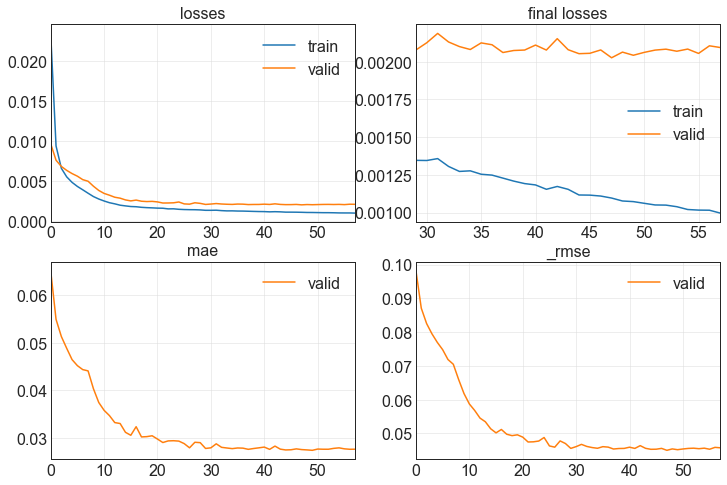

75.73359107971191                                                                                                      
[0.0009966423967853189, 0.002094465075060725, 0.027664534747600555, 0.04576532542705536]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 26%|███████████▏                               | 26/100 [32:07<1:27:42, 71.12s/trial, best loss: 0.002053575124591589]

No improvement since epoch 22: early stopping                                                                          
 26%|███████████▏                               | 26/100 [32:31<1:27:42, 71.12s/trial, best loss: 0.002053575124591589]

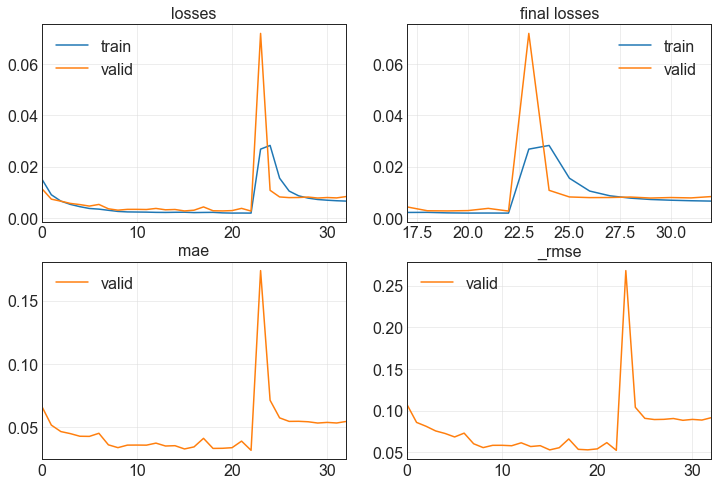

24.887657165527344                                                                                                     
[0.006626640446484089, 0.00839325226843357, 0.054648350924253464, 0.09161469340324402]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 27%|███████████▌                               | 27/100 [32:33<1:10:05, 57.61s/trial, best loss: 0.002053575124591589]

No improvement since epoch 36: early stopping                                                                          
 27%|███████████▌                               | 27/100 [33:34<1:10:05, 57.61s/trial, best loss: 0.002053575124591589]

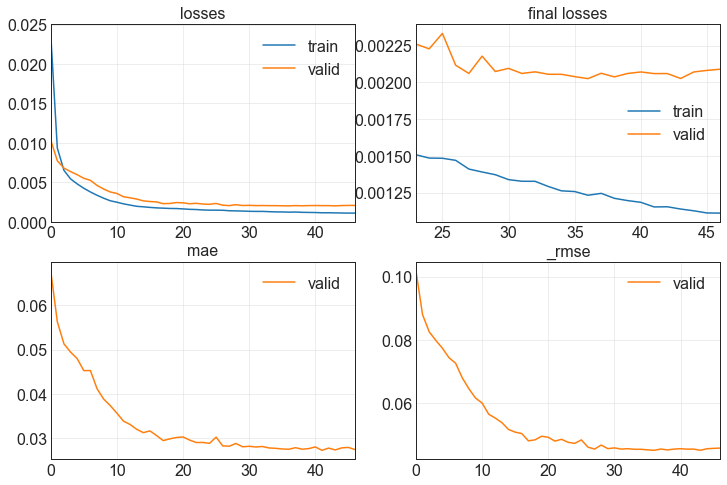

61.24386692047119                                                                                                      
[0.0011102496646344662, 0.002088837092742324, 0.027373677119612694, 0.04570379853248596]                               
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 28%|████████████                               | 28/100 [33:36<1:10:52, 59.07s/trial, best loss: 0.002053575124591589]

No improvement since epoch 7: early stopping                                                                           
 28%|████████████                               | 28/100 [34:00<1:10:52, 59.07s/trial, best loss: 0.002053575124591589]

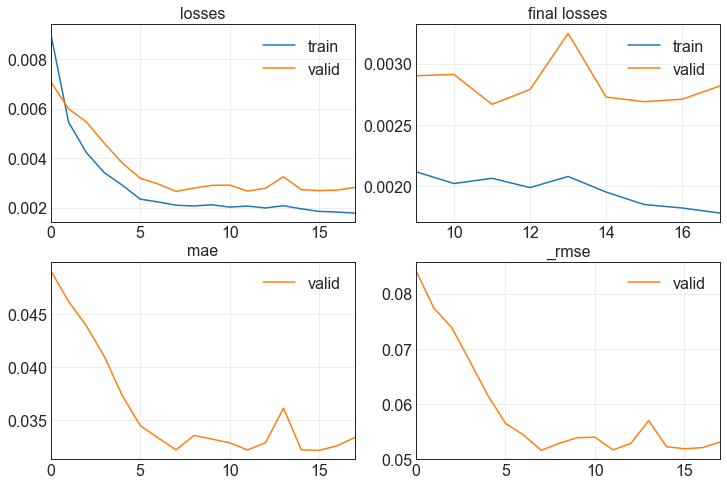

24.460460662841797                                                                                                     
[0.0017814019229263067, 0.002819574438035488, 0.03341569006443024, 0.05309966579079628]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 29%|█████████████                                | 29/100 [34:01<58:02, 49.05s/trial, best loss: 0.002053575124591589]

No improvement since epoch 39: early stopping                                                                          
 29%|█████████████                                | 29/100 [35:07<58:02, 49.05s/trial, best loss: 0.002053575124591589]

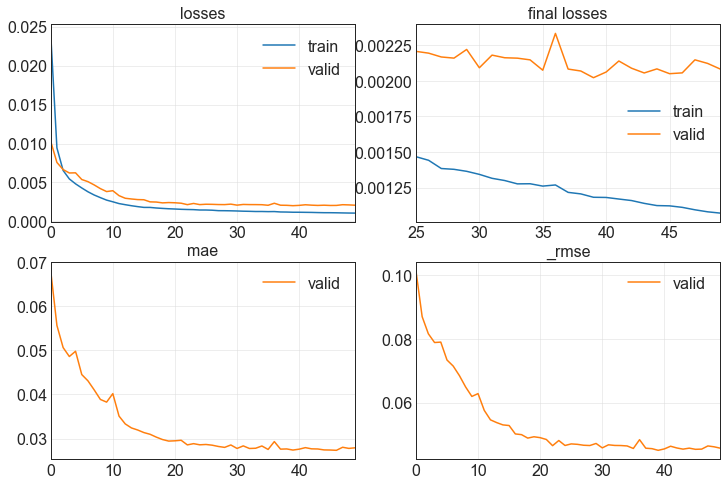

66.71104431152344                                                                                                      
[0.0010701037244871259, 0.0020837201736867428, 0.027885468676686287, 0.04564778506755829]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 30%|████████████▉                              | 30/100 [35:09<1:03:49, 54.71s/trial, best loss: 0.002053575124591589]

No improvement since epoch 29: early stopping                                                                          
 30%|████████████▉                              | 30/100 [36:47<1:03:49, 54.71s/trial, best loss: 0.002053575124591589]

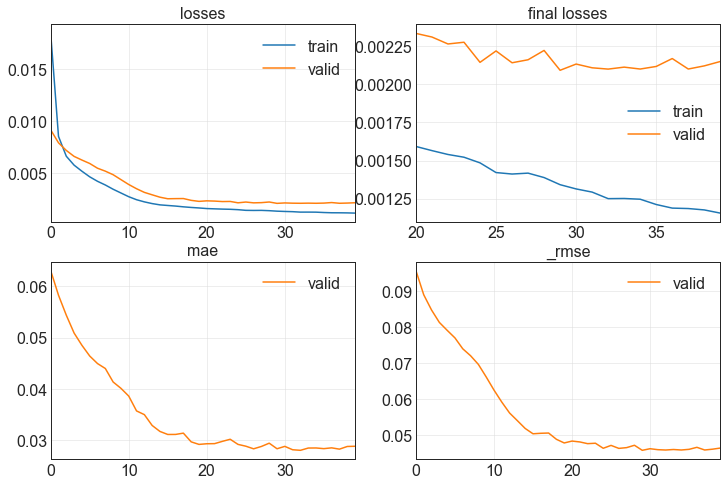

98.17707324028015                                                                                                      
[0.0011553725926205516, 0.0021490443032234907, 0.028867317363619804, 0.046357784420251846]                             
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 31%|█████████████▎                             | 31/100 [36:48<1:18:19, 68.11s/trial, best loss: 0.002053575124591589]

No improvement since epoch 33: early stopping                                                                          
 31%|█████████████▎                             | 31/100 [38:17<1:18:19, 68.11s/trial, best loss: 0.002053575124591589]

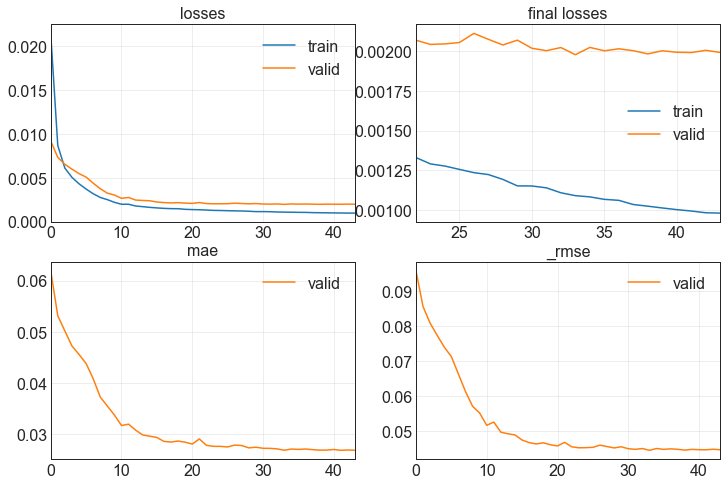

89.05981612205505                                                                                                      
[0.0009810422779992223, 0.001992418896406889, 0.0269033070653677, 0.044636521488428116]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 32%|█████████████▊                             | 32/100 [38:19<1:24:41, 74.73s/trial, best loss: 0.001992418896406889]

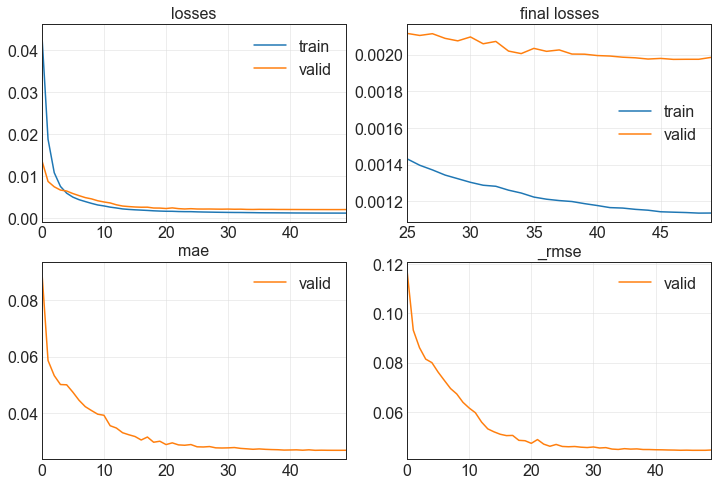

56.198556900024414                                                                                                     
[0.0011352879228070378, 0.0019847452640533447, 0.02678544633090496, 0.04455048218369484]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 33%|█████████████▊                            | 33/100 [39:16<1:17:36, 69.51s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 30: early stopping                                                                          
 33%|█████████████▊                            | 33/100 [39:58<1:17:36, 69.51s/trial, best loss: 0.0019847452640533447]

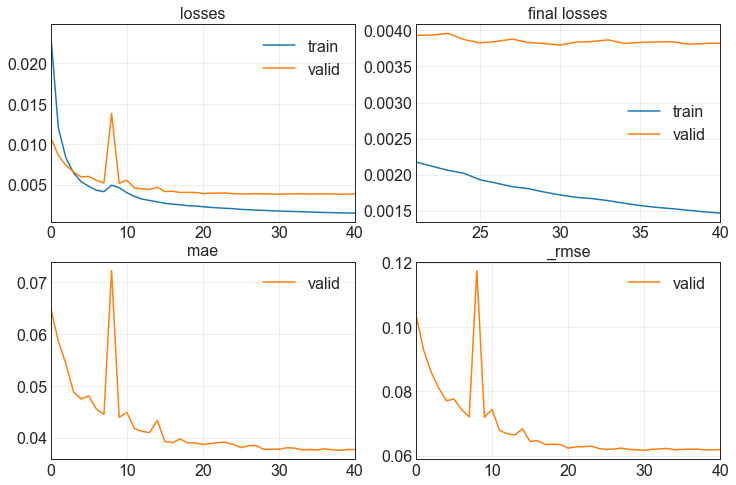

42.58386826515198                                                                                                      
[0.0014667077921330929, 0.0038236049003899097, 0.037714652717113495, 0.061835307627916336]                             
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 34%|██████████████▎                           | 34/100 [40:00<1:07:56, 61.77s/trial, best loss: 0.0019847452640533447]

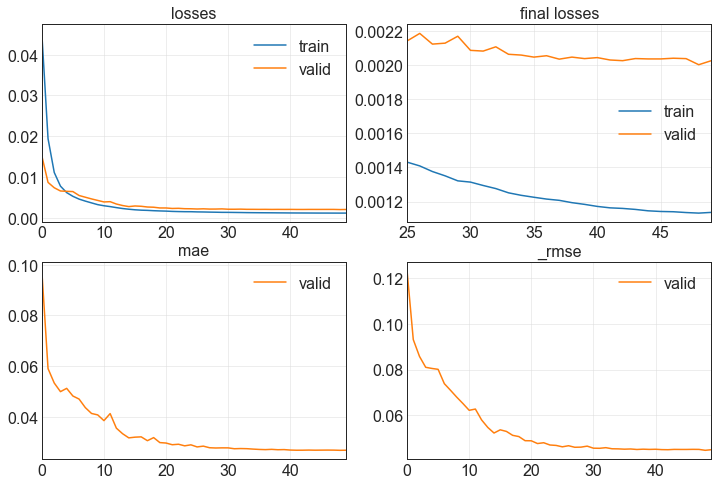

56.891905069351196                                                                                                     
[0.0011370135471224785, 0.0020251574460417032, 0.026888692751526833, 0.04500175267457962]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 35%|██████████████▋                           | 35/100 [40:58<1:05:42, 60.65s/trial, best loss: 0.0019847452640533447]

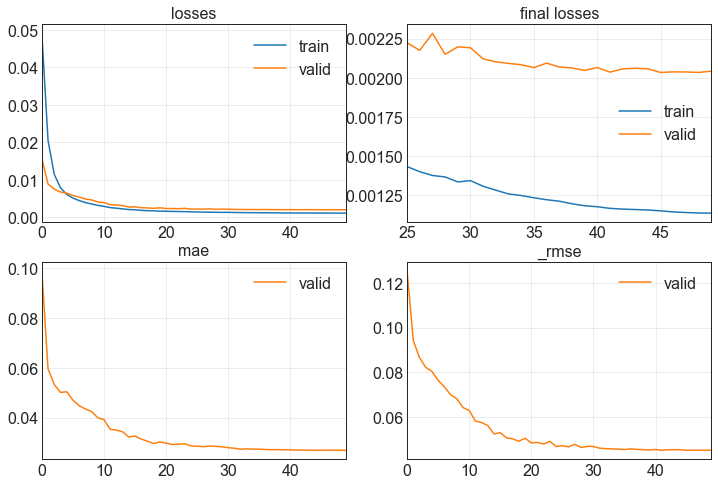

57.535674810409546                                                                                                     
[0.0011355708120390773, 0.002042383886873722, 0.026892803609371185, 0.04519273713231087]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 36%|███████████████                           | 36/100 [41:56<1:04:03, 60.05s/trial, best loss: 0.0019847452640533447]

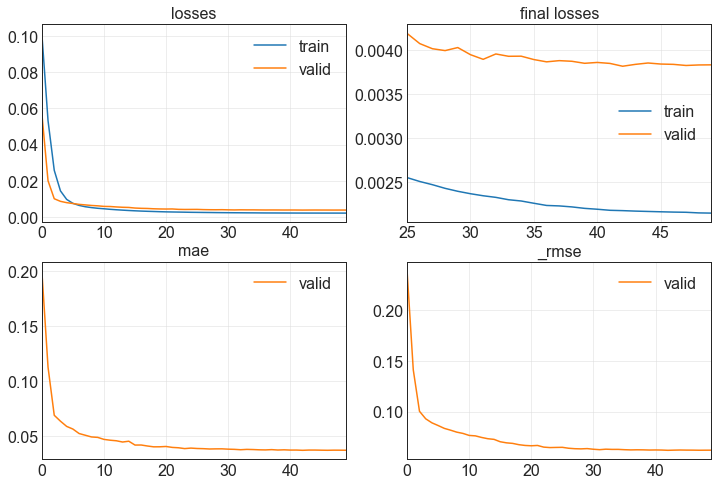

53.50249481201172                                                                                                      
[0.0021425578743219376, 0.0038314310368150473, 0.0371890589594841, 0.061898551881313324]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 37%|███████████████▌                          | 37/100 [42:51<1:01:22, 58.45s/trial, best loss: 0.0019847452640533447]

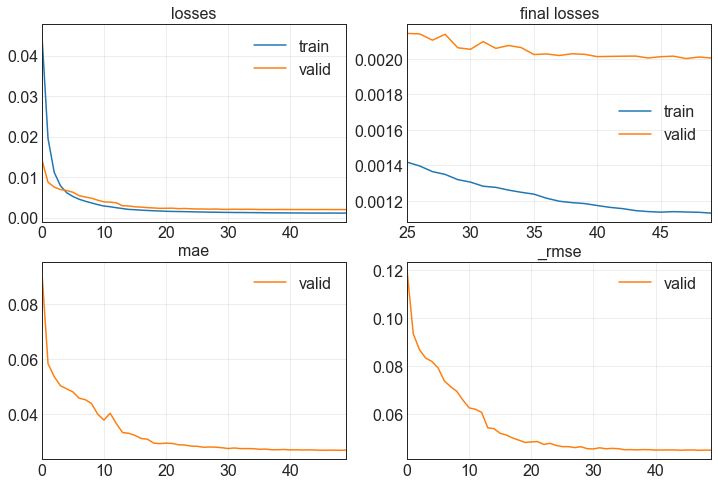

56.49471688270569                                                                                                      
[0.0011314223520457745, 0.00200463249348104, 0.027027573436498642, 0.044773124158382416]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 38%|███████████████▉                          | 38/100 [43:49<1:00:09, 58.21s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 6: early stopping                                                                           
 38%|███████████████▉                          | 38/100 [44:08<1:00:09, 58.21s/trial, best loss: 0.0019847452640533447]

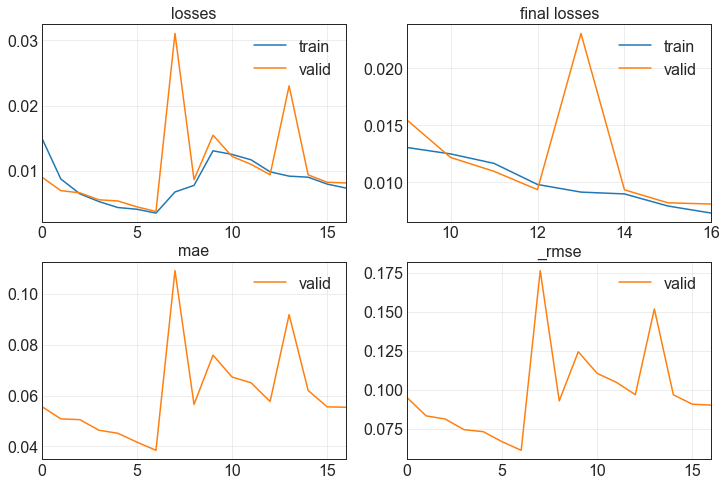

19.949565887451172                                                                                                     
[0.007319068536162376, 0.008110424503684044, 0.05539332330226898, 0.09005790203809738]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 39%|█████████████████▏                          | 39/100 [44:10<47:51, 47.08s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 28: early stopping                                                                          
 39%|█████████████████▏                          | 39/100 [46:48<47:51, 47.08s/trial, best loss: 0.0019847452640533447]

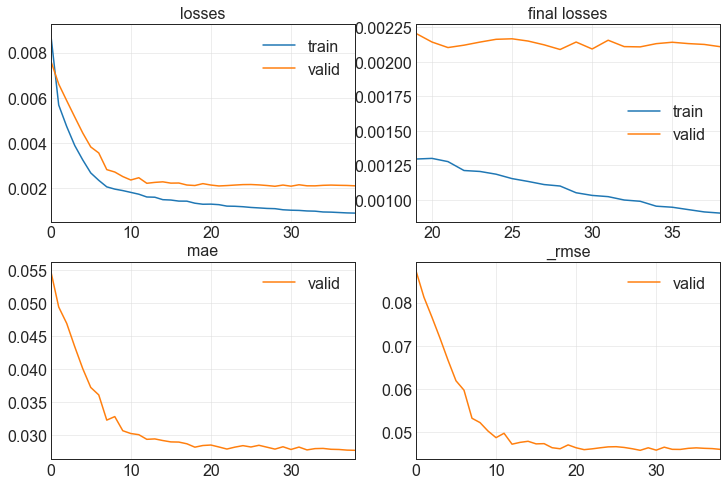

158.09507822990417                                                                                                     
[0.0009048031643033028, 0.0021105215419083834, 0.027716411277651787, 0.04594041407108307]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 40%|████████████████▊                         | 40/100 [46:49<1:20:44, 80.74s/trial, best loss: 0.0019847452640533447]

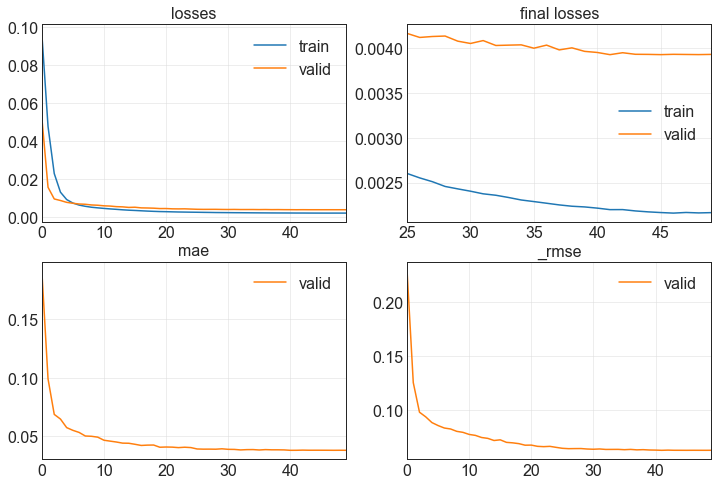

62.83164834976196                                                                                                      
[0.002164190635085106, 0.003933305386453867, 0.03785122185945511, 0.06271607428789139]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 41%|█████████████████▏                        | 41/100 [47:53<1:14:27, 75.72s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 25: early stopping                                                                          
 41%|█████████████████▏                        | 41/100 [49:59<1:14:27, 75.72s/trial, best loss: 0.0019847452640533447]

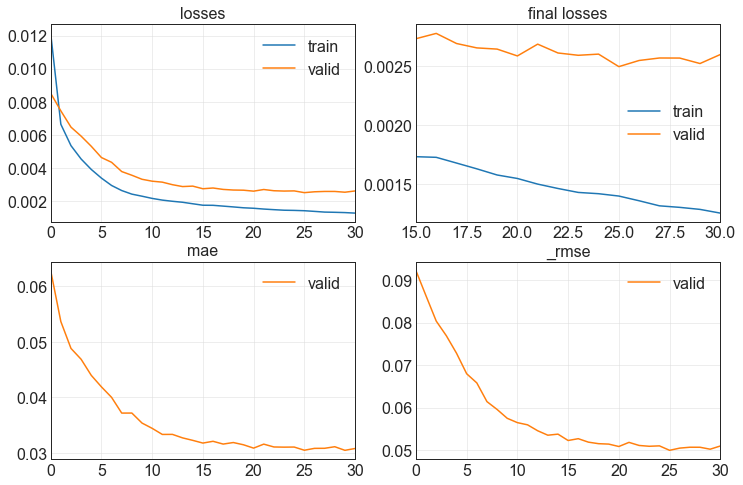

126.65928864479065                                                                                                     
[0.0012541493633762002, 0.0025959208142012358, 0.03081277385354042, 0.05095018446445465]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 42%|█████████████████▋                        | 42/100 [50:01<1:28:17, 91.33s/trial, best loss: 0.0019847452640533447]

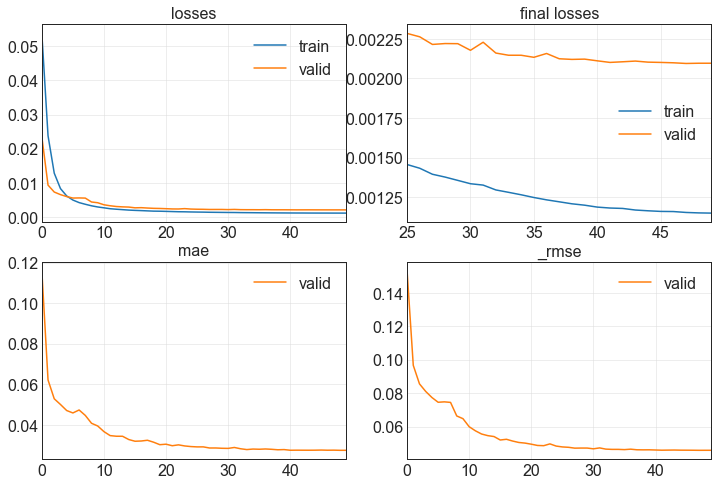

26.074060440063477                                                                                                     
[0.0011504044523462653, 0.0020963484421372414, 0.027477947995066643, 0.045785896480083466]                             
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 20, 'lr': 0.01, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 43%|██████████████████                        | 43/100 [50:28<1:08:29, 72.09s/trial, best loss: 0.0019847452640533447]

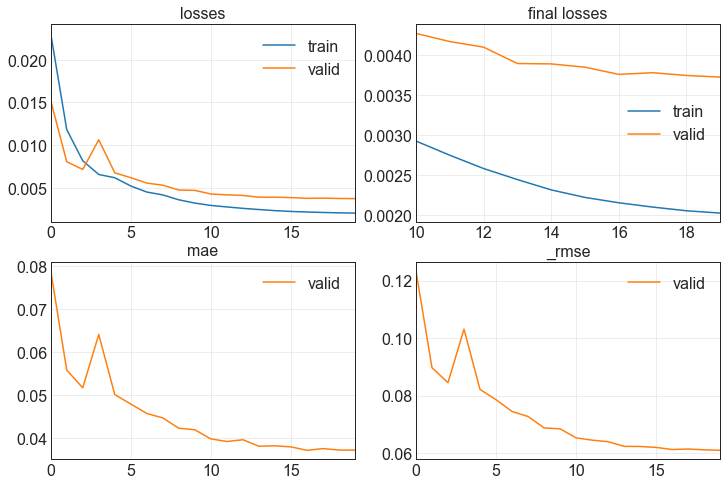

21.720293760299683                                                                                                     
[0.0020284252241253853, 0.0037262002006173134, 0.037296514958143234, 0.06104261055588722]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 44%|███████████████████▎                        | 44/100 [50:51<53:31, 57.34s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 38: early stopping                                                                          
 44%|███████████████████▎                        | 44/100 [54:47<53:31, 57.34s/trial, best loss: 0.0019847452640533447]

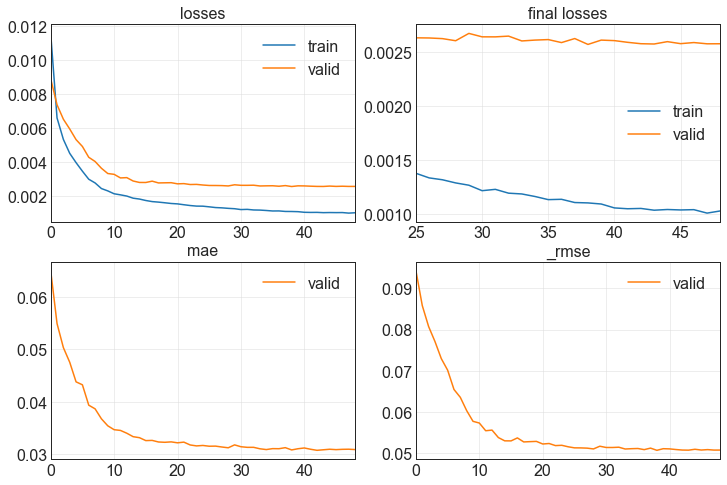

236.6236400604248                                                                                                      
[0.0010313903912901878, 0.0025772966910153627, 0.030869396403431892, 0.05076707899570465]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 45%|██████████████████▍                      | 45/100 [54:49<1:42:10, 111.46s/trial, best loss: 0.0019847452640533447]

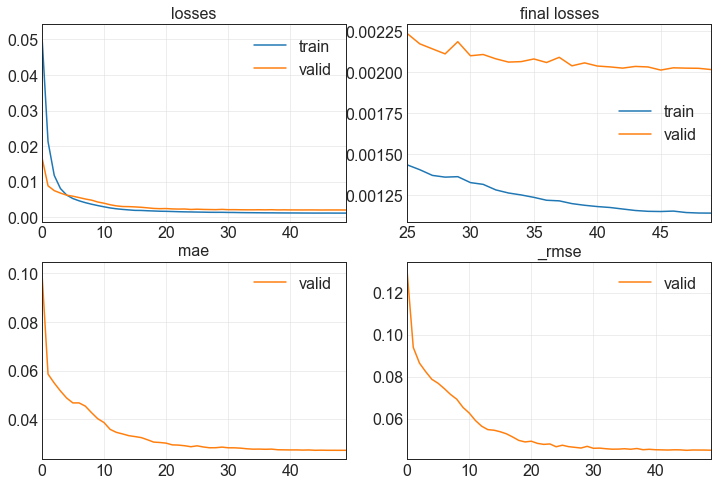

57.266438245773315                                                                                                     
[0.0011387354461476207, 0.002014624187722802, 0.02726556360721588, 0.044884566217660904]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 46%|███████████████████▎                      | 46/100 [55:47<1:26:00, 95.56s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 1: early stopping                                                                           
 46%|███████████████████▎                      | 46/100 [56:27<1:26:00, 95.56s/trial, best loss: 0.0019847452640533447]

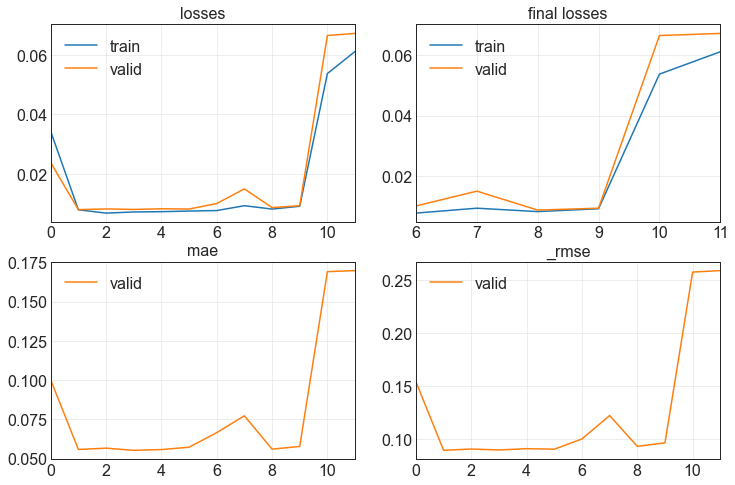

40.5955126285553                                                                                                       
[0.06113744154572487, 0.06721663475036621, 0.16972121596336365, 0.25926169753074646]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 47%|███████████████████▋                      | 47/100 [56:29<1:10:08, 79.41s/trial, best loss: 0.0019847452640533447]

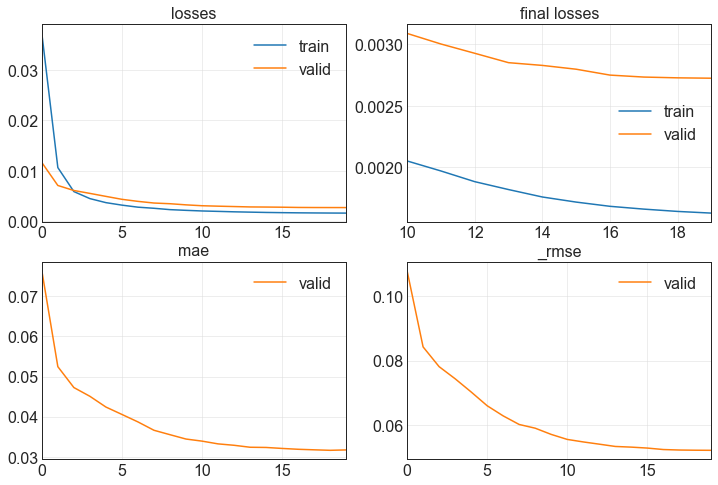

19.55855107307434                                                                                                      
[0.0016292004147544503, 0.0027247534599155188, 0.03172657638788223, 0.052199169993400574]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.1, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 48%|█████████████████████                       | 48/100 [56:50<53:33, 61.80s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 3: early stopping                                                                           
 48%|█████████████████████                       | 48/100 [57:05<53:33, 61.80s/trial, best loss: 0.0019847452640533447]

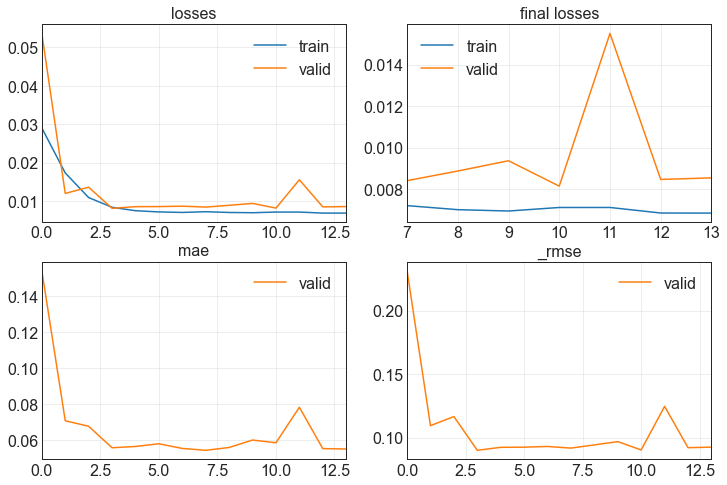

15.664087533950806                                                                                                     
[0.006836283951997757, 0.008537337183952332, 0.055007610470056534, 0.09239771962165833]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 49%|█████████████████████▌                      | 49/100 [57:07<41:04, 48.32s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 4: early stopping                                                                           
 49%|█████████████████████▌                      | 49/100 [57:31<41:04, 48.32s/trial, best loss: 0.0019847452640533447]

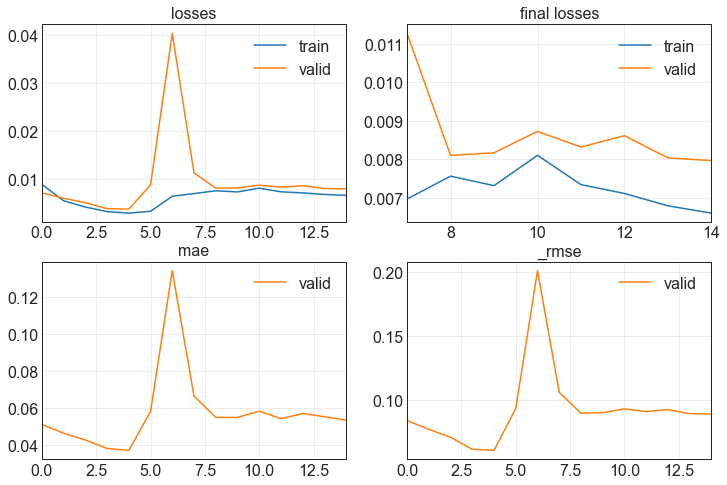

25.332534074783325                                                                                                     
[0.006601232569664717, 0.007966732606291771, 0.053632237017154694, 0.08925655484199524]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 50%|██████████████████████                      | 50/100 [57:33<34:48, 41.77s/trial, best loss: 0.0019847452640533447]

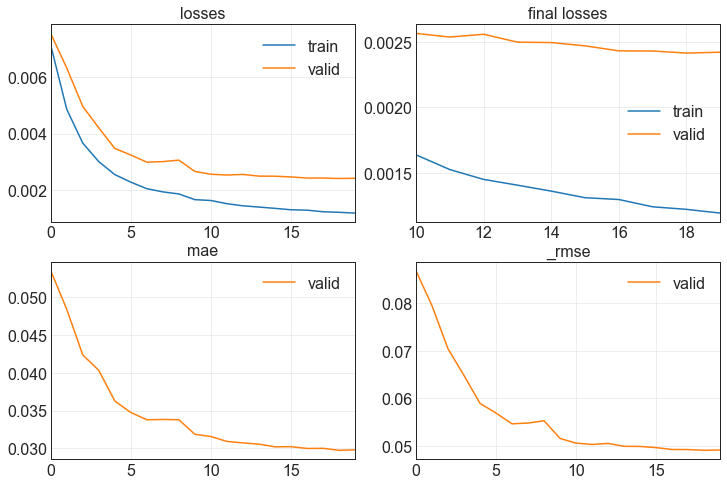

164.0971360206604                                                                                                      
[0.001193189062178135, 0.0024209930561482906, 0.029781155288219452, 0.04920359328389168]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 51%|████████████████████▍                   | 51/100 [1:00:18<1:04:21, 78.80s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 3: early stopping                                                                           
 51%|████████████████████▍                   | 51/100 [1:01:27<1:04:21, 78.80s/trial, best loss: 0.0019847452640533447]

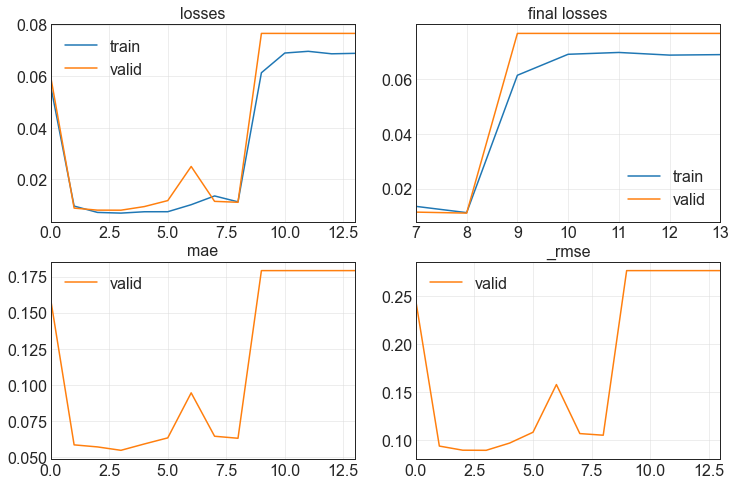

69.29942440986633                                                                                                      
[0.06887457519769669, 0.07660936564207077, 0.1790732592344284, 0.2767839729785919]                                     
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 52%|████████████████████▊                   | 52/100 [1:01:29<1:01:02, 76.31s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 31: early stopping                                                                          
 52%|████████████████████▊                   | 52/100 [1:03:58<1:01:02, 76.31s/trial, best loss: 0.0019847452640533447]

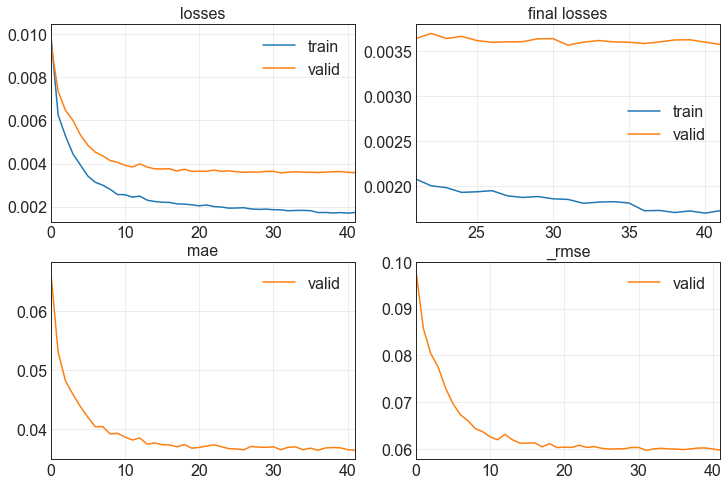

149.5572464466095                                                                                                      
[0.0017292010597884655, 0.0035745834466069937, 0.0363403744995594, 0.059787817299366]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 53%|█████████████████████▏                  | 53/100 [1:04:00<1:17:16, 98.65s/trial, best loss: 0.0019847452640533447]

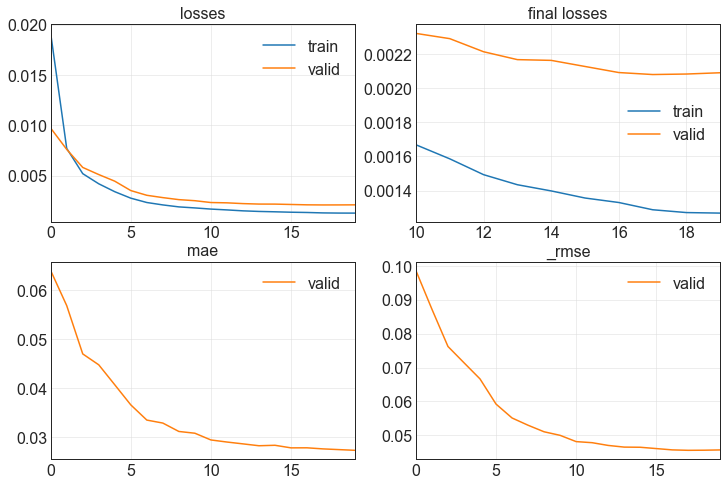

42.25601387023926                                                                                                      
[0.0012687360867857933, 0.002090031746774912, 0.027369430288672447, 0.045716866850852966]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 54%|█████████████████████▌                  | 54/100 [1:04:43<1:02:56, 82.10s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 7: early stopping                                                                           
 54%|█████████████████████▌                  | 54/100 [1:04:59<1:02:56, 82.10s/trial, best loss: 0.0019847452640533447]

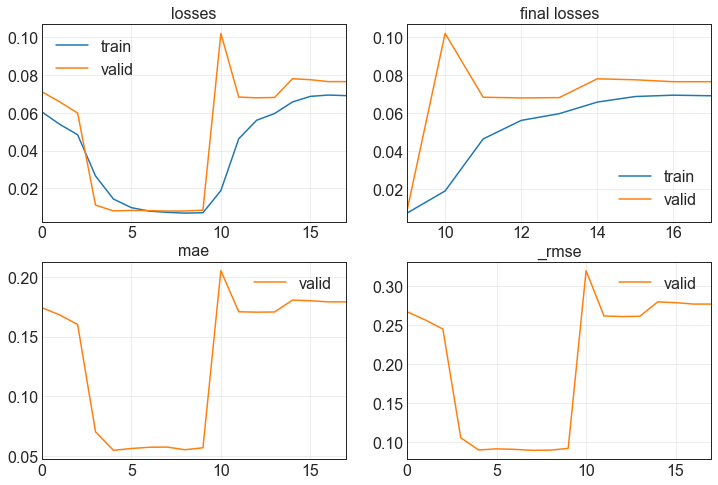

16.853490591049194                                                                                                     
[0.06917037069797516, 0.07660917937755585, 0.1790797859430313, 0.27678364515304565]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 55%|███████████████████████                   | 55/100 [1:05:01<47:08, 62.87s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 8: early stopping                                                                           
 55%|███████████████████████                   | 55/100 [1:05:40<47:08, 62.87s/trial, best loss: 0.0019847452640533447]

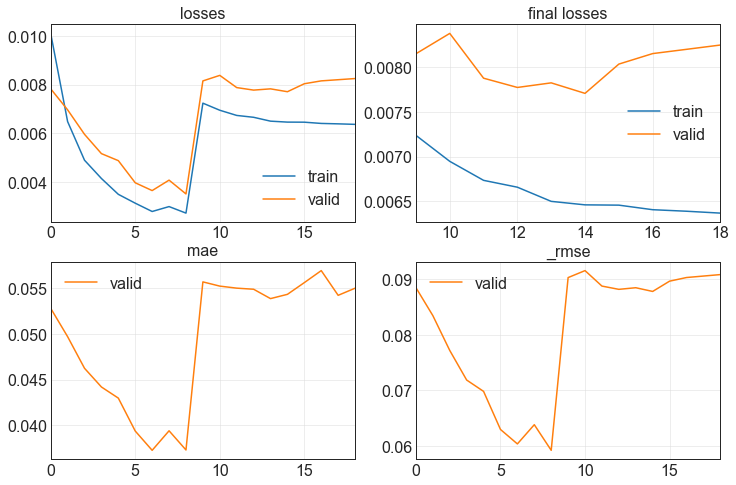

39.39582347869873                                                                                                      
[0.006367047317326069, 0.008250916376709938, 0.05500137433409691, 0.09083455801010132]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 10}
TST                                                                                                                    
 56%|███████████████████████▌                  | 56/100 [1:05:41<41:11, 56.17s/trial, best loss: 0.0019847452640533447]

No improvement since epoch 23: early stopping                                                                          
 56%|███████████████████████▌                  | 56/100 [1:07:44<41:11, 56.17s/trial, best loss: 0.0019847452640533447]

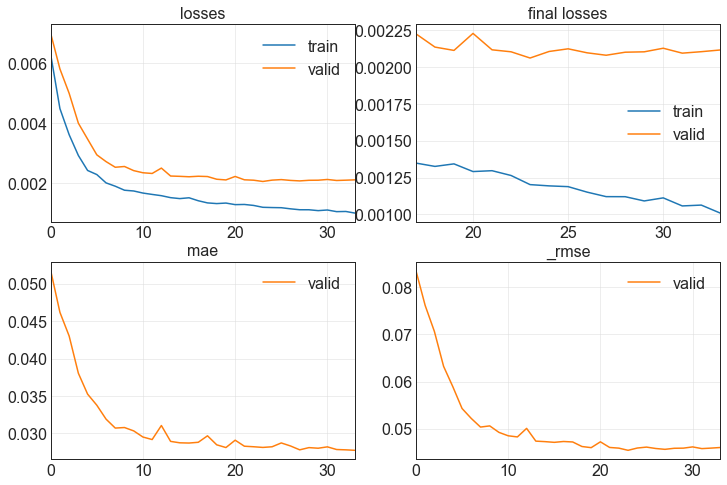

122.88232445716858                                                                                                     
[0.0010092079173773527, 0.0021147767547518015, 0.027754534035921097, 0.04598669707775116]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 57%|███████████████████████▉                  | 57/100 [1:07:46<54:50, 76.53s/trial, best loss: 0.0019847452640533447]

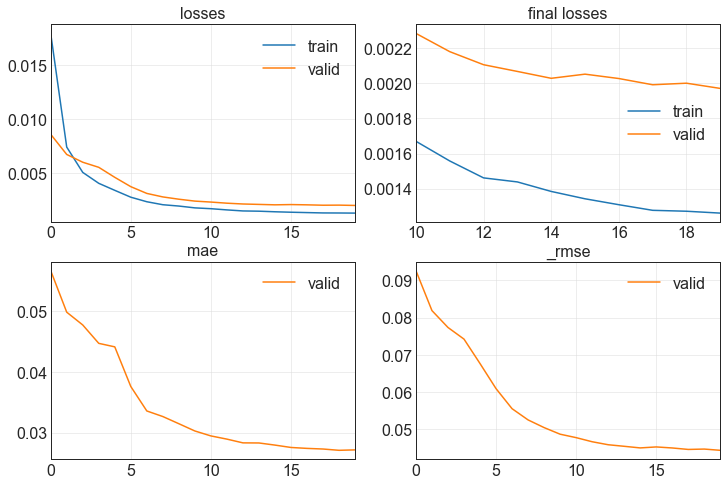

41.704803466796875                                                                                                     
[0.0012610359117388725, 0.00197128439322114, 0.02713698334991932, 0.04439914971590042]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 20, 'lr': 0.1, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 58%|█████████████████████████▌                  | 58/100 [1:08:28<46:30, 66.44s/trial, best loss: 0.00197128439322114]

No improvement since epoch 3: early stopping                                                                           
 58%|█████████████████████████▌                  | 58/100 [1:08:40<46:30, 66.44s/trial, best loss: 0.00197128439322114]

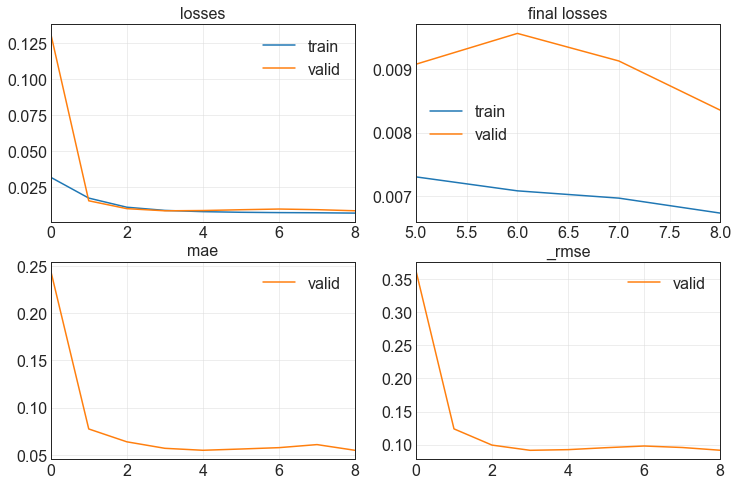

11.77945351600647                                                                                                      
[0.00672965357080102, 0.008353248238563538, 0.05475051328539848, 0.09139610826969147]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 59%|█████████████████████████▉                  | 59/100 [1:08:41<34:26, 50.40s/trial, best loss: 0.00197128439322114]

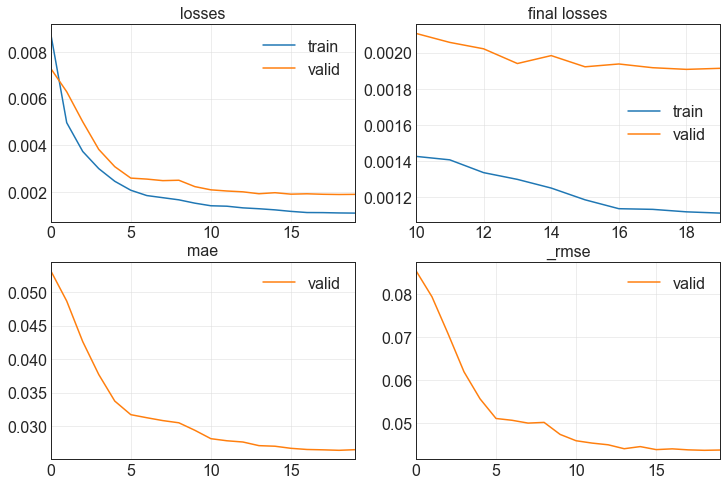

66.36773943901062                                                                                                      
[0.0011131697101518512, 0.001913681742735207, 0.026484312489628792, 0.04374564439058304]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 60%|█████████████████████████▊                 | 60/100 [1:09:49<37:01, 55.53s/trial, best loss: 0.001913681742735207]

No improvement since epoch 2: early stopping                                                                           
 60%|█████████████████████████▊                 | 60/100 [1:10:17<37:01, 55.53s/trial, best loss: 0.001913681742735207]

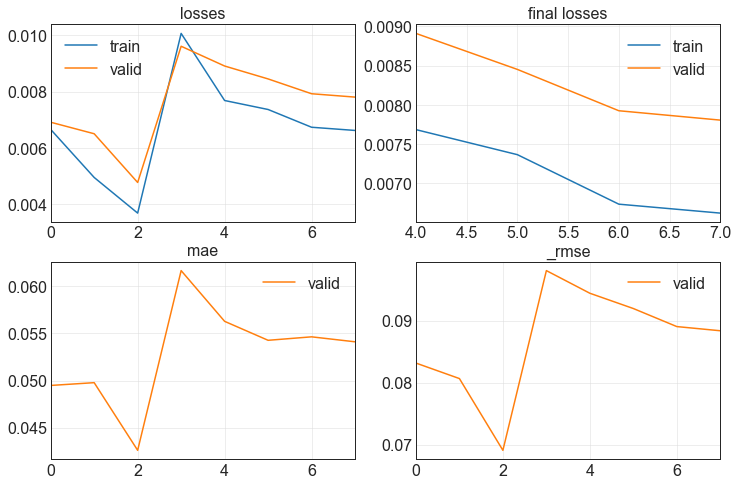

28.122106313705444                                                                                                     
[0.00662131467834115, 0.007805354427546263, 0.054107218980789185, 0.0883479192852974]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 61%|██████████████████████████▏                | 61/100 [1:10:18<30:58, 47.66s/trial, best loss: 0.001913681742735207]

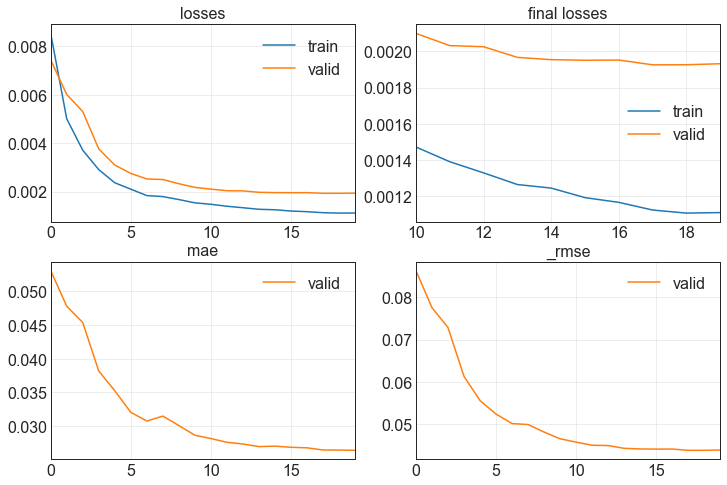

67.84072041511536                                                                                                      
[0.0011106872698292136, 0.0019321219297125936, 0.02641306445002556, 0.043955910950899124]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 62%|██████████████████████████▋                | 62/100 [1:11:27<34:14, 54.06s/trial, best loss: 0.001913681742735207]

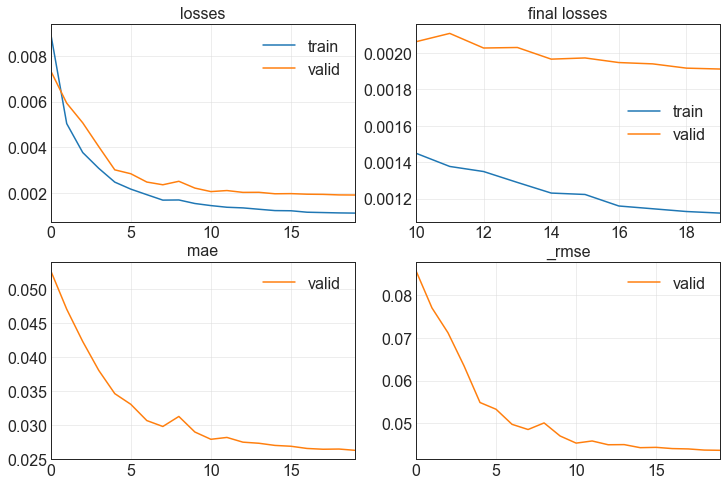

67.26150321960449                                                                                                      
[0.001120727858506143, 0.00191159185487777, 0.02624618262052536, 0.043721754103899]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 63%|███████████████████████████▋                | 63/100 [1:12:36<35:59, 58.37s/trial, best loss: 0.00191159185487777]

No improvement since epoch 1: early stopping                                                                           
 63%|███████████████████████████▋                | 63/100 [1:12:59<35:59, 58.37s/trial, best loss: 0.00191159185487777]

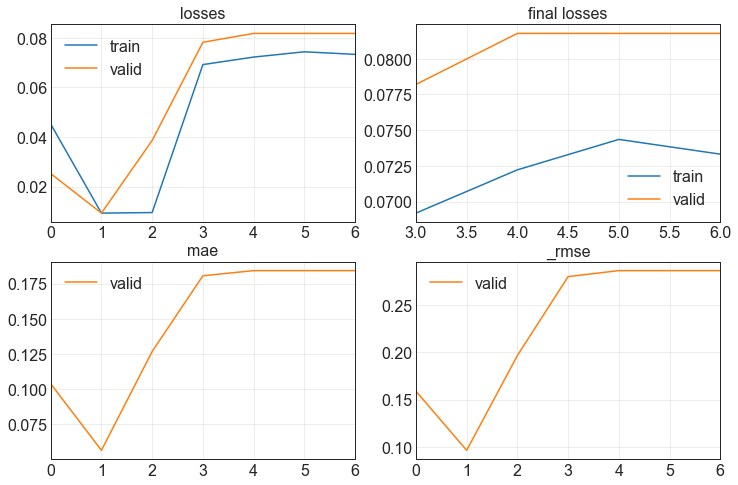

23.81315040588379                                                                                                      
[0.07332311570644379, 0.08177144080400467, 0.18423528969287872, 0.28595706820487976]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 64%|████████████████████████████▏               | 64/100 [1:13:01<29:01, 48.38s/trial, best loss: 0.00191159185487777]

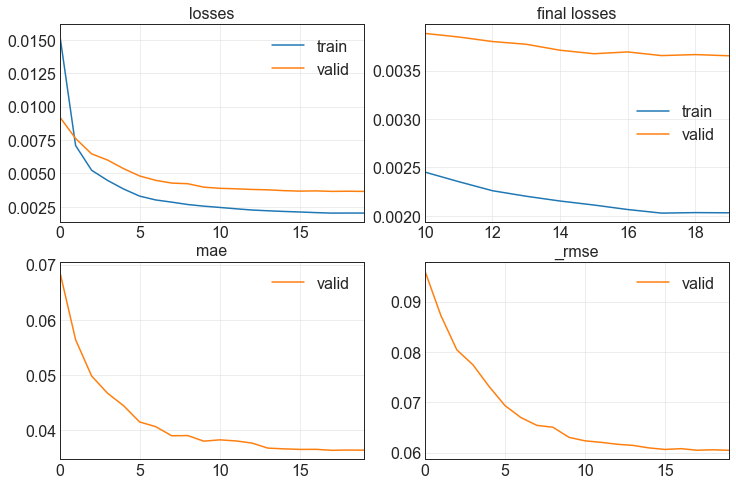

66.7691490650177                                                                                                       
[0.0020304310601204634, 0.003652375191450119, 0.03634988144040108, 0.06043488532304764]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 65%|████████████████████████████▌               | 65/100 [1:14:09<31:39, 54.26s/trial, best loss: 0.00191159185487777]

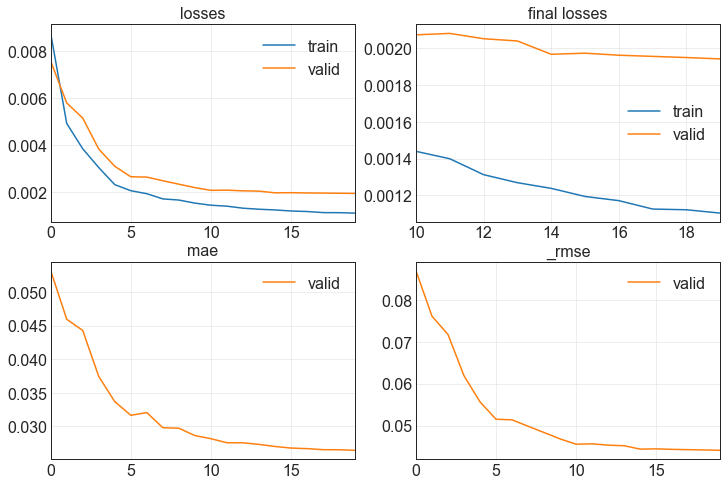

69.57539820671082                                                                                                      
[0.001103502232581377, 0.0019423166522756219, 0.026434751227498055, 0.04407172277569771]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 66%|█████████████████████████████               | 66/100 [1:15:19<33:32, 59.20s/trial, best loss: 0.00191159185487777]

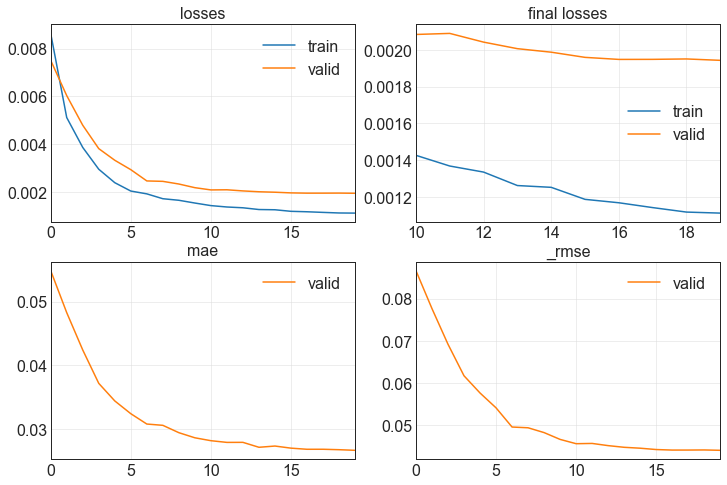

68.08574938774109                                                                                                      
[0.0011130365310236812, 0.0019429646199569106, 0.026676474139094353, 0.044079072773456573]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 67%|█████████████████████████████▍              | 67/100 [1:16:29<34:13, 62.23s/trial, best loss: 0.00191159185487777]

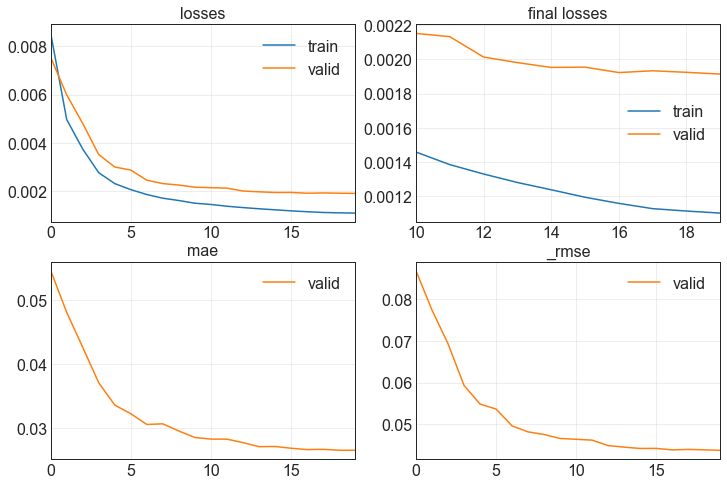

68.91722083091736                                                                                                      
[0.0011003585532307625, 0.0019143004901707172, 0.026577608659863472, 0.04375271871685982]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 68%|█████████████████████████████▉              | 68/100 [1:17:39<34:28, 64.63s/trial, best loss: 0.00191159185487777]

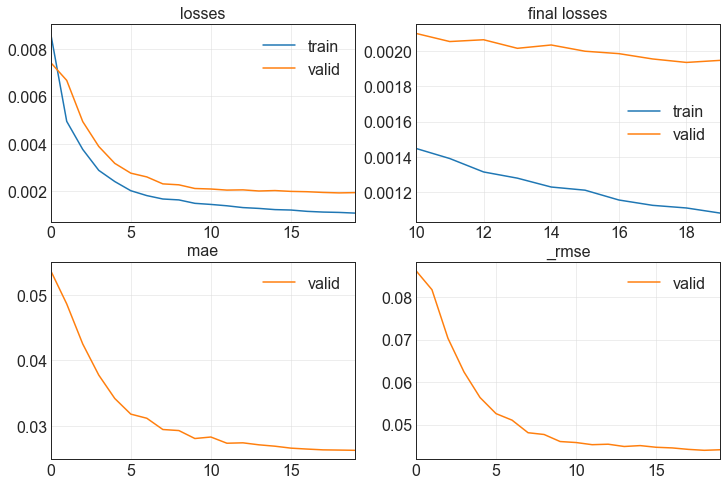

68.43344521522522                                                                                                      
[0.001082799630239606, 0.0019461403135210276, 0.02625182271003723, 0.04411507770419121]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 69%|██████████████████████████████▎             | 69/100 [1:18:49<34:09, 66.13s/trial, best loss: 0.00191159185487777]

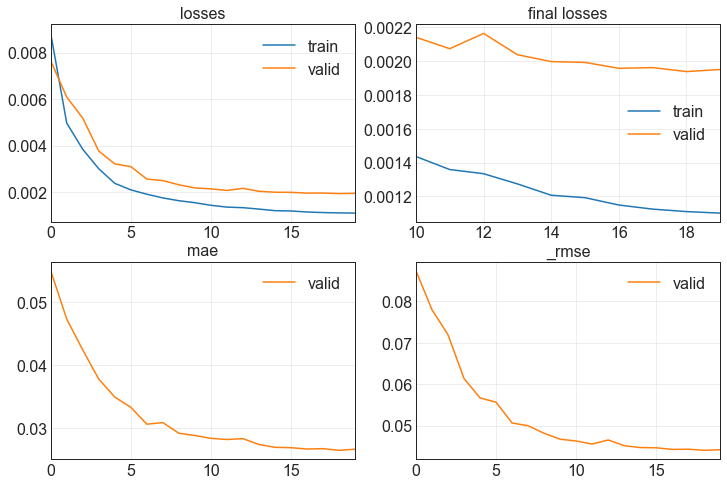

66.92734670639038                                                                                                      
[0.001100810244679451, 0.0019509659614413977, 0.0266720000654459, 0.04416973516345024]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 70%|██████████████████████████████▊             | 70/100 [1:19:57<33:21, 66.73s/trial, best loss: 0.00191159185487777]

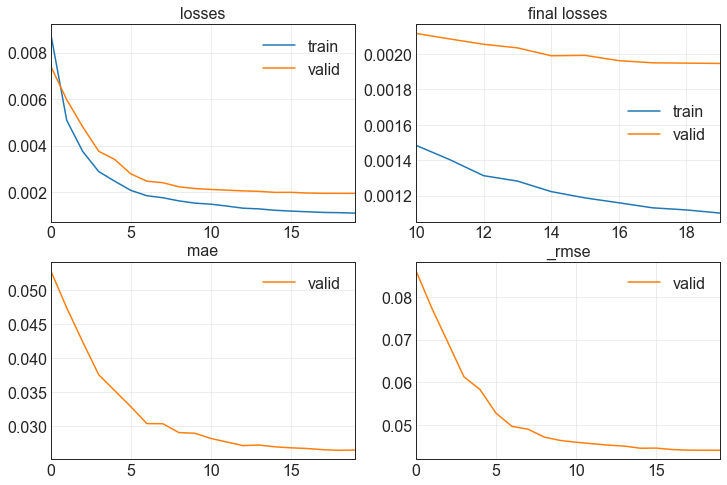

66.90051364898682                                                                                                      
[0.0011005080305039883, 0.0019473843276500702, 0.026514263823628426, 0.044129181653261185]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 71%|███████████████████████████████▏            | 71/100 [1:21:05<32:27, 67.14s/trial, best loss: 0.00191159185487777]

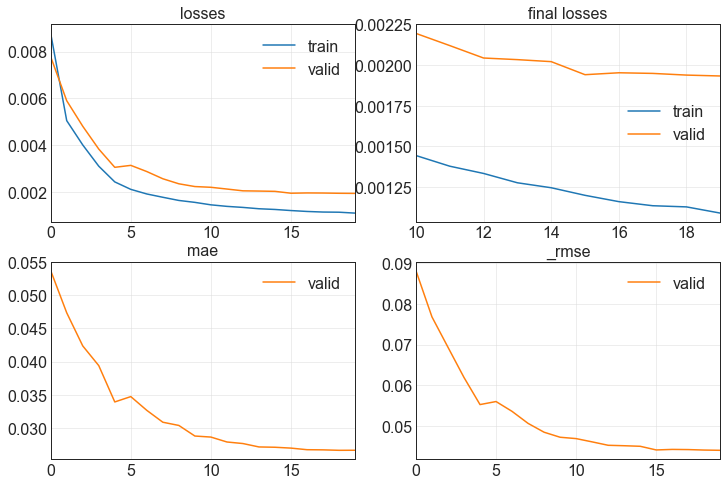

68.37674570083618                                                                                                      
[0.001090404111891985, 0.0019334240350872278, 0.026674149557948112, 0.04397071897983551]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 72%|███████████████████████████████▋            | 72/100 [1:22:14<31:40, 67.87s/trial, best loss: 0.00191159185487777]

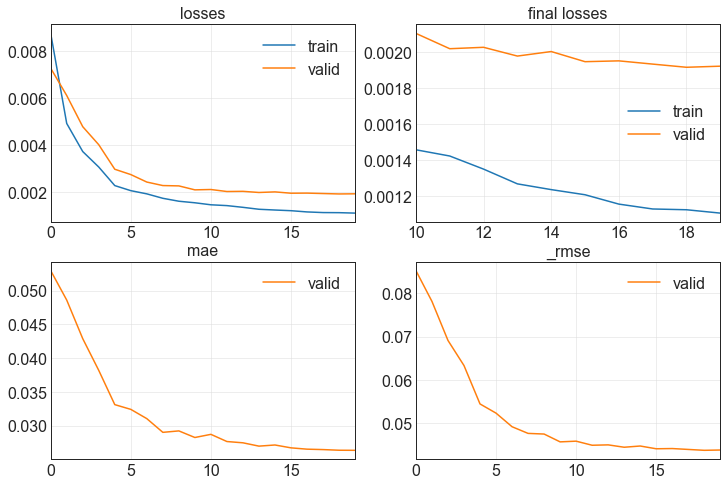

70.10715126991272                                                                                                      
[0.0011033597402274609, 0.0019236082443967462, 0.026347072795033455, 0.043858952820301056]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 73%|████████████████████████████████            | 73/100 [1:23:26<31:00, 68.91s/trial, best loss: 0.00191159185487777]

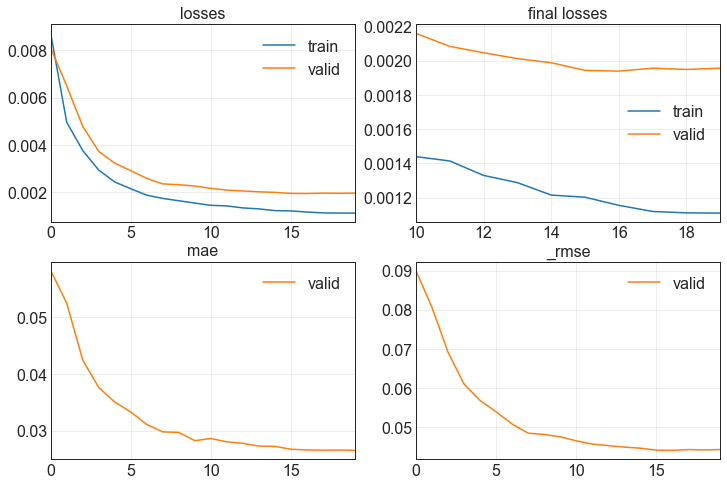

68.6212089061737                                                                                                       
[0.0011096991365775466, 0.001956002088263631, 0.026523437350988388, 0.044226713478565216]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 74%|████████████████████████████████▌           | 74/100 [1:24:36<29:58, 69.18s/trial, best loss: 0.00191159185487777]

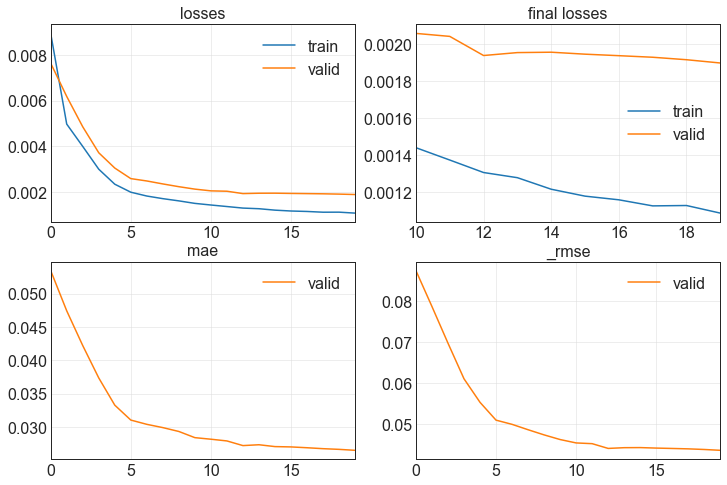

67.89843106269836                                                                                                      
[0.0010870618280023336, 0.0018984258640557528, 0.02647569216787815, 0.043570928275585175]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 75%|███████████████████████████████▌          | 75/100 [1:25:45<28:48, 69.16s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 1: early stopping                                                                           
 75%|███████████████████████████████▌          | 75/100 [1:26:08<28:48, 69.16s/trial, best loss: 0.0018984258640557528]

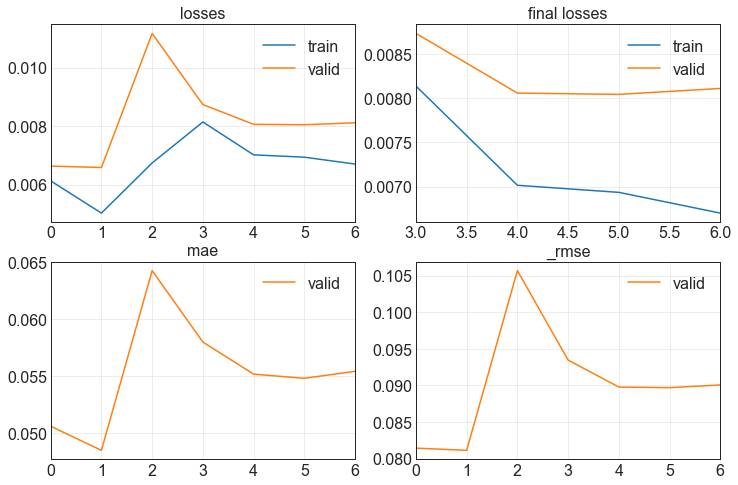

24.14313769340515                                                                                                      
[0.006701142992824316, 0.008111145347356796, 0.05541888624429703, 0.09006189554929733]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 76%|███████████████████████████████▉          | 76/100 [1:26:10<22:24, 56.01s/trial, best loss: 0.0018984258640557528]

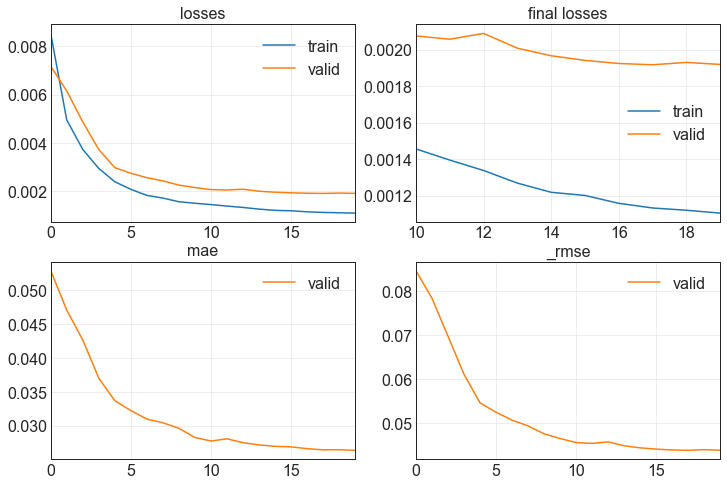

69.19650316238403                                                                                                      
[0.001103425514884293, 0.0019188737496733665, 0.02634020522236824, 0.04380495101213455]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 77%|████████████████████████████████▎         | 77/100 [1:27:20<23:07, 60.33s/trial, best loss: 0.0018984258640557528]

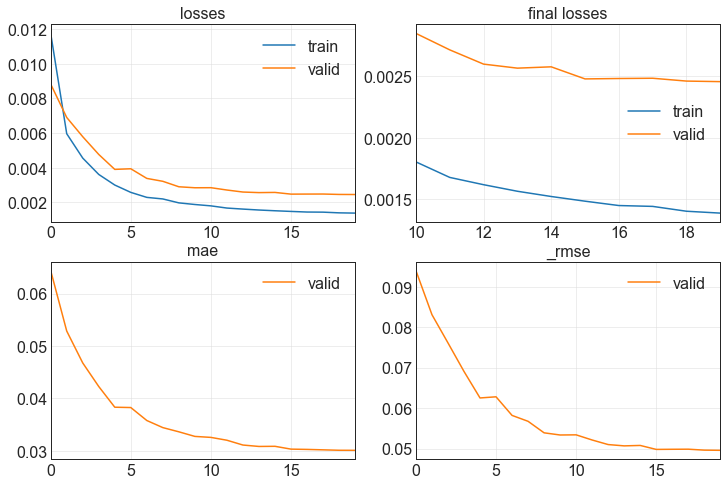

67.64264822006226                                                                                                      
[0.0013848048401996493, 0.002457948634400964, 0.030092917382717133, 0.049577705562114716]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 78%|████████████████████████████████▊         | 78/100 [1:28:29<23:03, 62.89s/trial, best loss: 0.0018984258640557528]

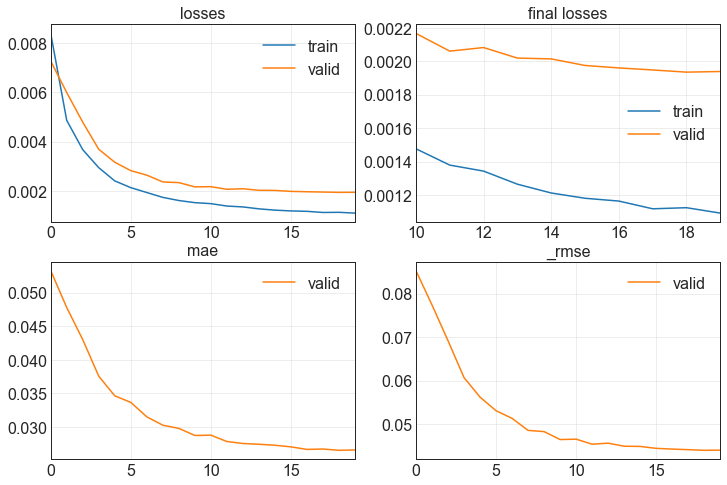

66.22416019439697                                                                                                      
[0.001091302721761167, 0.0019384719198569655, 0.026581227779388428, 0.04402808099985123]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 79%|█████████████████████████████████▏        | 79/100 [1:29:37<22:29, 64.25s/trial, best loss: 0.0018984258640557528]

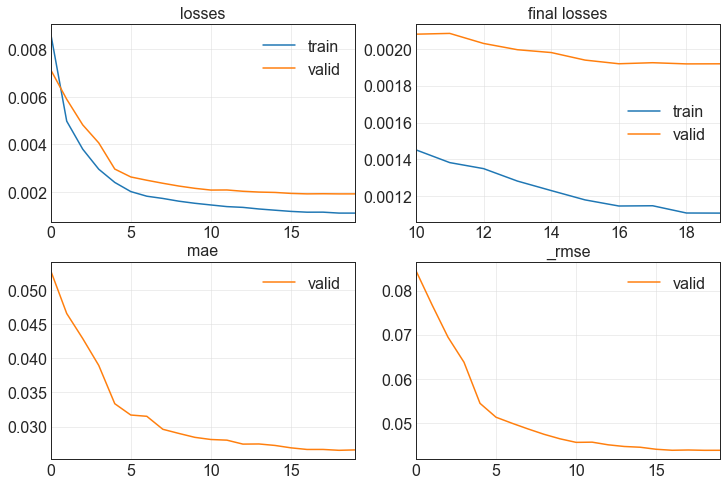

66.21483731269836                                                                                                      
[0.0011093381326645613, 0.001918313093483448, 0.02656812220811844, 0.043798550963401794]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 80%|█████████████████████████████████▌        | 80/100 [1:30:44<21:43, 65.20s/trial, best loss: 0.0018984258640557528]

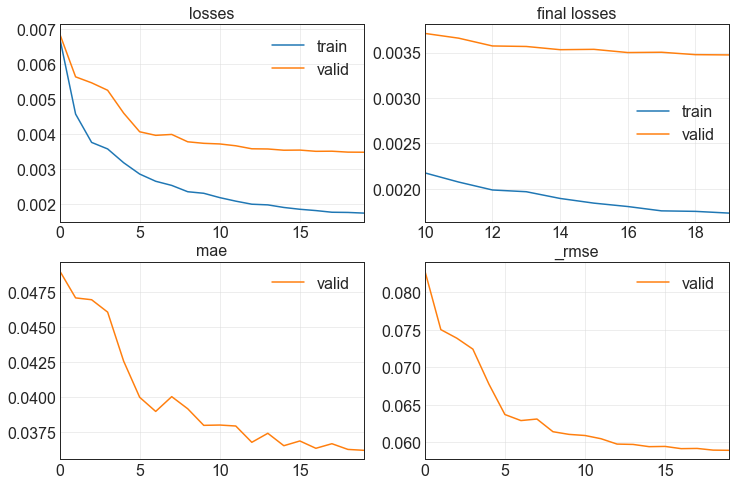

35.06562066078186                                                                                                      
[0.0017327970126643777, 0.00347377872094512, 0.03619212284684181, 0.05893877148628235]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 81%|██████████████████████████████████        | 81/100 [1:31:20<17:53, 56.50s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 0: early stopping                                                                           
 81%|██████████████████████████████████        | 81/100 [1:32:19<17:53, 56.50s/trial, best loss: 0.0018984258640557528]

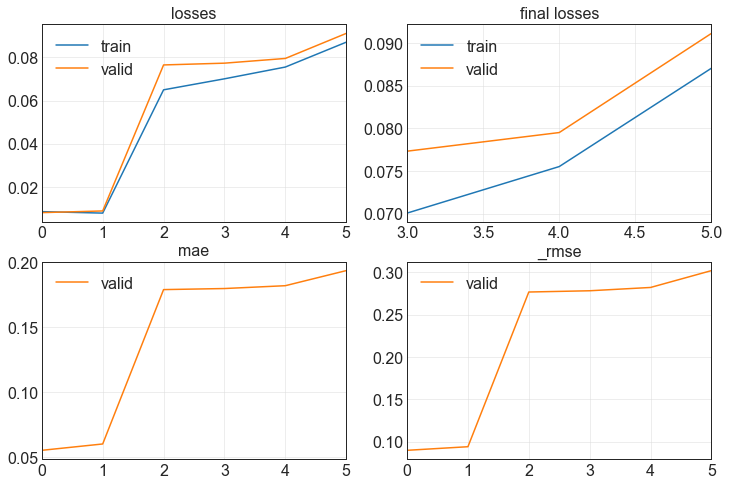

59.118263483047485                                                                                                     
[0.08703587204217911, 0.09111291915178299, 0.19357679784297943, 0.3018491566181183]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 82%|██████████████████████████████████▍       | 82/100 [1:32:21<17:17, 57.63s/trial, best loss: 0.0018984258640557528]

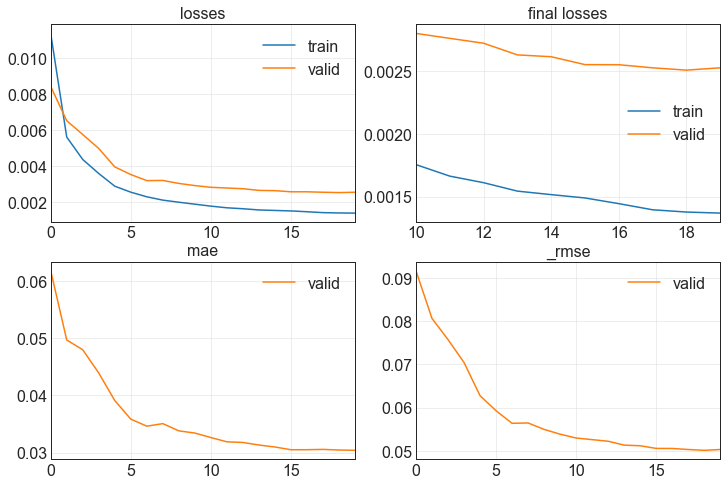

68.00891613960266                                                                                                      
[0.0013687225291505456, 0.002529177349060774, 0.030399616807699203, 0.05029092729091644]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 83%|██████████████████████████████████▊       | 83/100 [1:33:30<17:18, 61.09s/trial, best loss: 0.0018984258640557528]

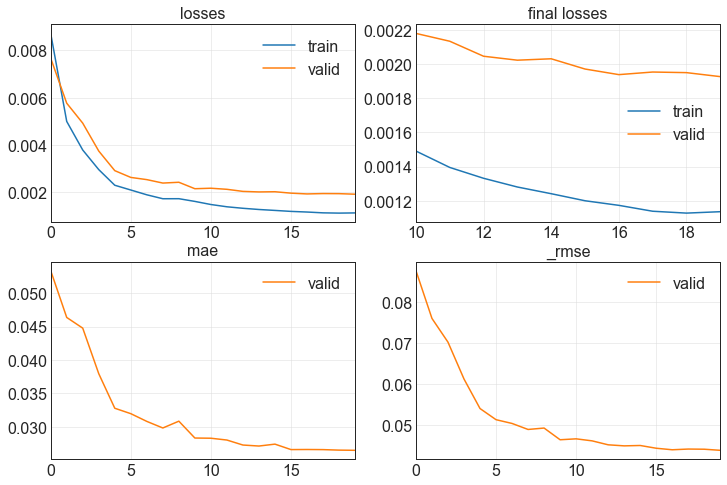

65.7726001739502                                                                                                       
[0.0011360887438058853, 0.0019260724075138569, 0.0264876838773489, 0.04388704523444176]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 84%|███████████████████████████████████▎      | 84/100 [1:34:37<16:45, 62.84s/trial, best loss: 0.0018984258640557528]

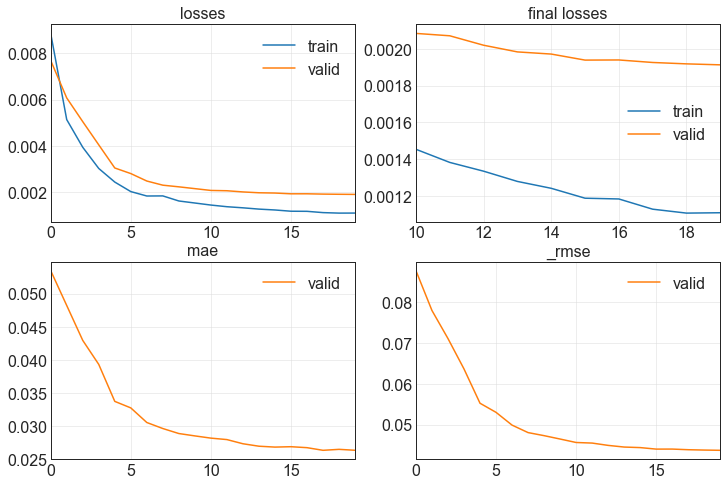

68.14454579353333                                                                                                      
[0.0011087734019383788, 0.0019129825523123145, 0.02635226957499981, 0.043737657368183136]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 85%|███████████████████████████████████▋      | 85/100 [1:35:46<16:11, 64.78s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 24: early stopping                                                                          
 85%|███████████████████████████████████▋      | 85/100 [1:38:19<16:11, 64.78s/trial, best loss: 0.0018984258640557528]

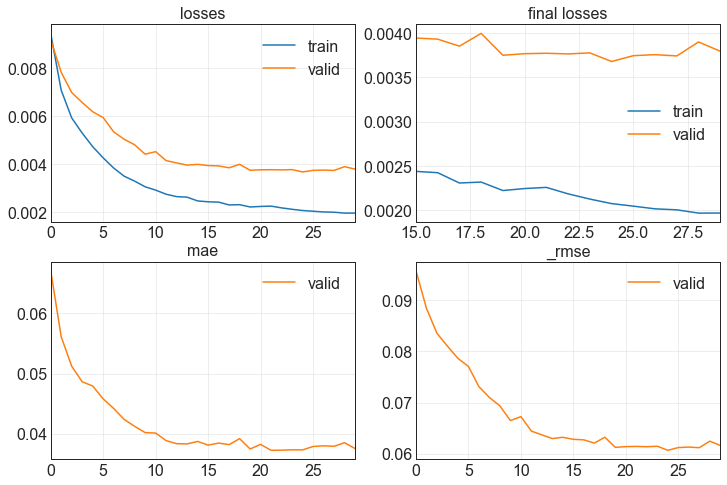

153.51362872123718                                                                                                     
[0.0019686887972056866, 0.00379416486248374, 0.03752175718545914, 0.06159680336713791]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 86%|████████████████████████████████████      | 86/100 [1:38:21<21:25, 91.79s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 4: early stopping                                                                           
 86%|████████████████████████████████████      | 86/100 [1:38:38<21:25, 91.79s/trial, best loss: 0.0018984258640557528]

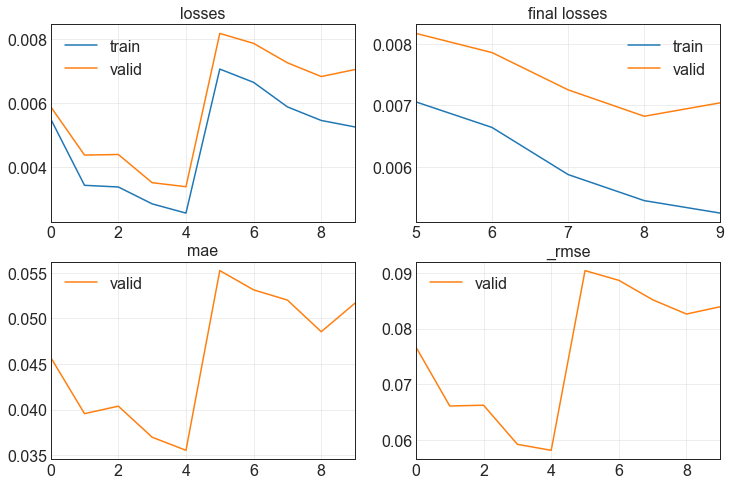

18.153442859649658                                                                                                     
[0.005251350346952677, 0.007043273188173771, 0.051688455045223236, 0.08392420411109924]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 87%|████████████████████████████████████▌     | 87/100 [1:38:40<15:10, 70.06s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 1: early stopping                                                                           
 87%|████████████████████████████████████▌     | 87/100 [1:39:14<15:10, 70.06s/trial, best loss: 0.0018984258640557528]

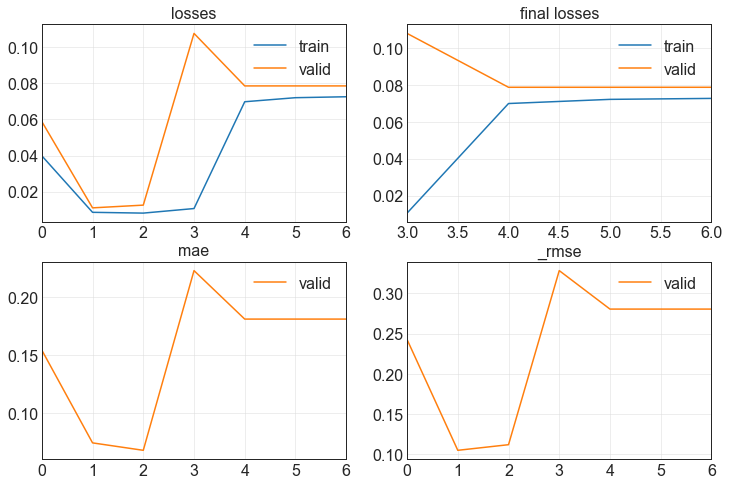

34.829819440841675                                                                                                     
[0.07261810451745987, 0.07863419502973557, 0.18110236525535583, 0.28041791915893555]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 88%|████████████████████████████████████▉     | 88/100 [1:39:16<11:58, 59.85s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 37: early stopping                                                                          
 88%|████████████████████████████████████▉     | 88/100 [1:41:37<11:58, 59.85s/trial, best loss: 0.0018984258640557528]

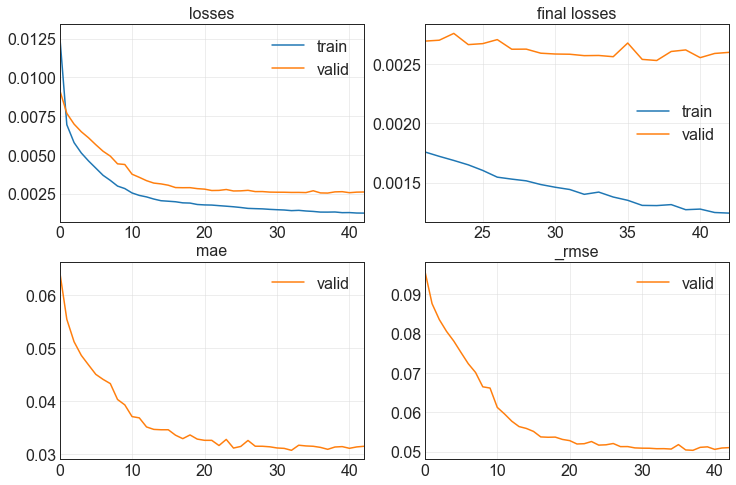

141.3992054462433                                                                                                      
[0.0012408752227202058, 0.002602417254820466, 0.03147857263684273, 0.05101389437913895]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 89%|█████████████████████████████████████▍    | 89/100 [1:41:39<15:31, 84.66s/trial, best loss: 0.0018984258640557528]

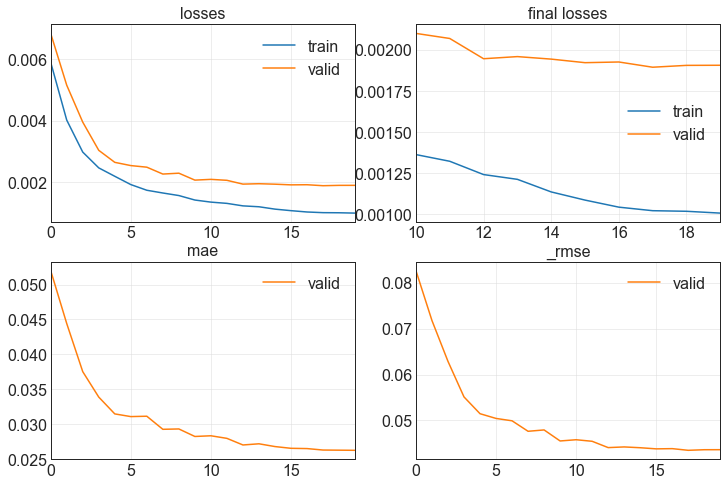

132.83338165283203                                                                                                     
[0.001005780417472124, 0.0019050949485972524, 0.02620934508740902, 0.0436473973095417]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 90%|█████████████████████████████████████▊    | 90/100 [1:43:53<16:34, 99.45s/trial, best loss: 0.0018984258640557528]

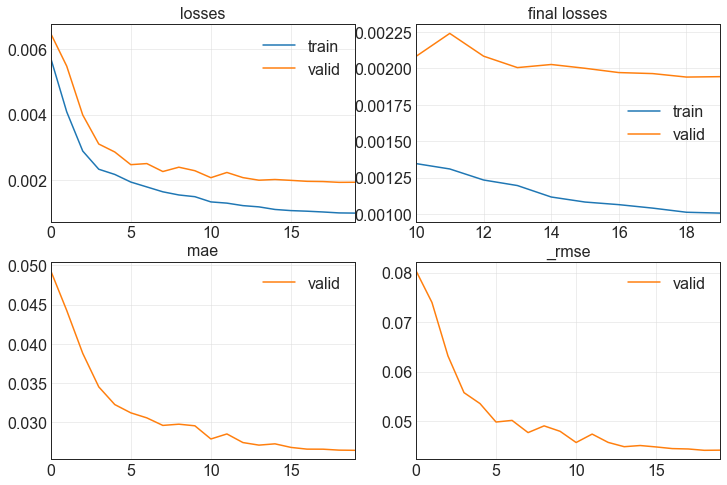

130.98489713668823                                                                                                     
[0.0010059812339022756, 0.0019435632275417447, 0.026424329727888107, 0.04408586025238037]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 91%|█████████████████████████████████████▎   | 91/100 [1:46:05<16:23, 109.27s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 0: early stopping                                                                           
 91%|█████████████████████████████████████▎   | 91/100 [1:46:34<16:23, 109.27s/trial, best loss: 0.0018984258640557528]

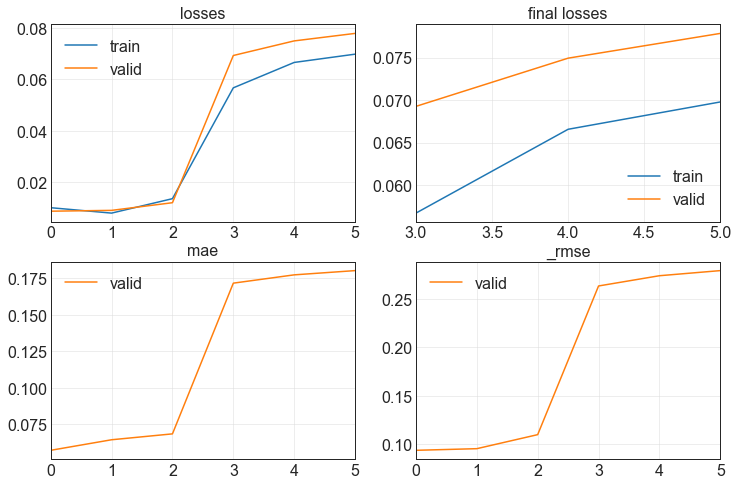

29.934492111206055                                                                                                     
[0.06978202611207962, 0.07784158736467361, 0.18030624091625214, 0.27900105714797974]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 92%|██████████████████████████████████████▋   | 92/100 [1:46:36<11:26, 85.81s/trial, best loss: 0.0018984258640557528]

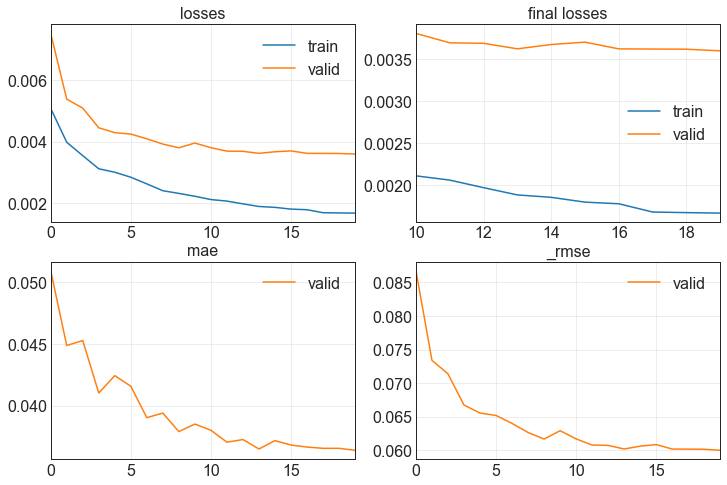

68.4351179599762                                                                                                       
[0.0016720888670533895, 0.0035968651063740253, 0.036372434347867966, 0.05997387692332268]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 93%|███████████████████████████████████████   | 93/100 [1:47:46<09:26, 80.93s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 21: early stopping                                                                          
 93%|███████████████████████████████████████   | 93/100 [1:52:01<09:26, 80.93s/trial, best loss: 0.0018984258640557528]

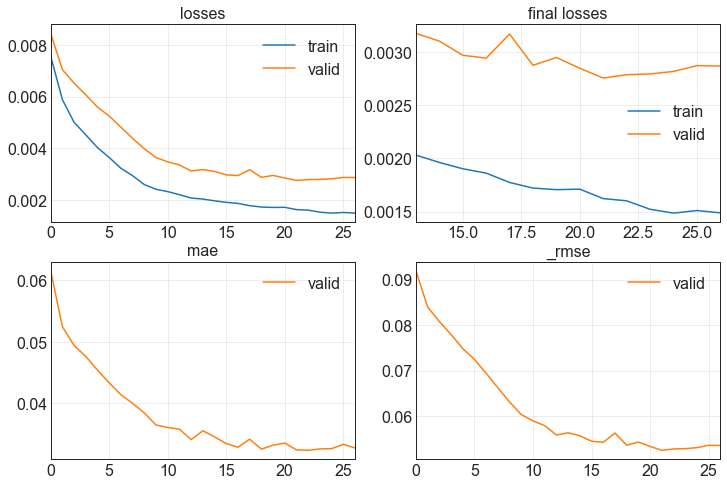

255.47965574264526                                                                                                     
[0.0014876493951305747, 0.002866429975256324, 0.032762520015239716, 0.05353905260562897]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 94%|██████████████████████████████████████▌  | 94/100 [1:52:02<13:21, 133.66s/trial, best loss: 0.0018984258640557528]

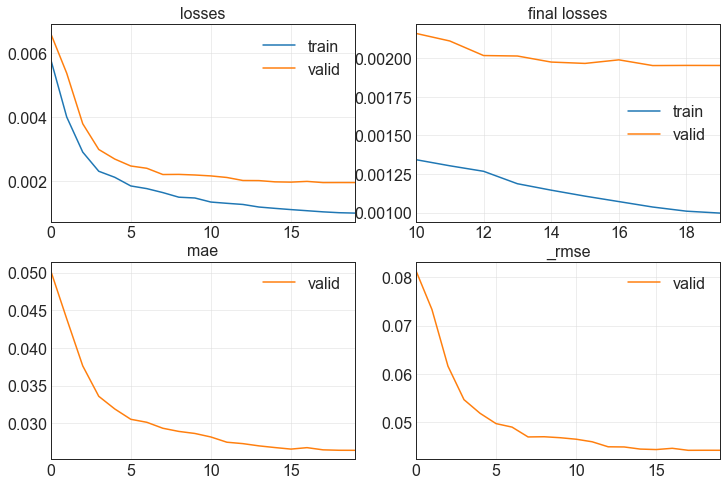

126.84930348396301                                                                                                     
[0.000996183604001999, 0.0019536258187144995, 0.02639644965529442, 0.044199831783771515]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 95%|██████████████████████████████████████▉  | 95/100 [1:54:10<10:59, 131.96s/trial, best loss: 0.0018984258640557528]

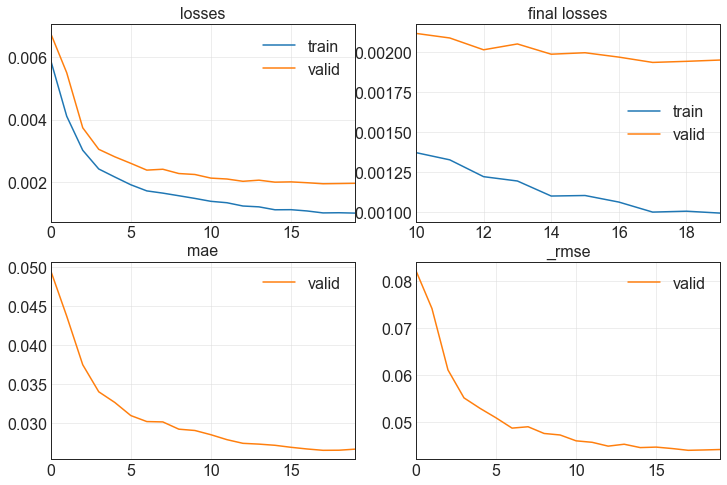

130.23810148239136                                                                                                     
[0.000993623398244381, 0.0019526520045474172, 0.026610054075717926, 0.04418882355093956]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 96%|███████████████████████████████████████▎ | 96/100 [1:56:21<08:47, 131.78s/trial, best loss: 0.0018984258640557528]

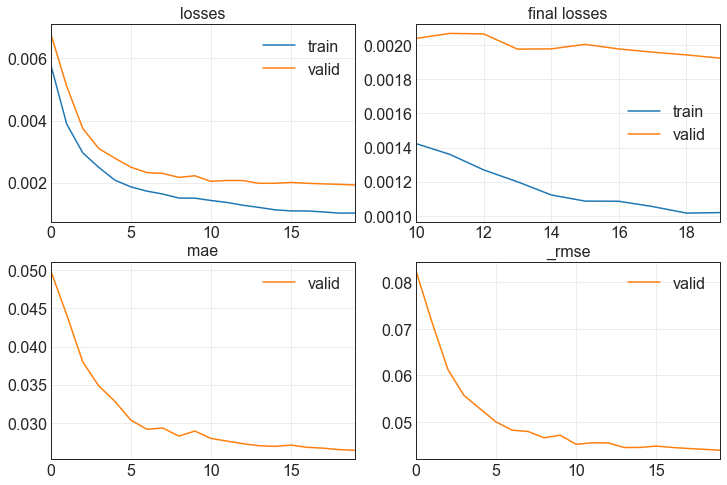

103.28433108329773                                                                                                     
[0.0010191722540184855, 0.001923685660585761, 0.026398660615086555, 0.04385983571410179]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 97%|███████████████████████████████████████▊ | 97/100 [1:58:06<06:10, 123.58s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 6: early stopping                                                                           
 97%|███████████████████████████████████████▊ | 97/100 [1:59:27<06:10, 123.58s/trial, best loss: 0.0018984258640557528]

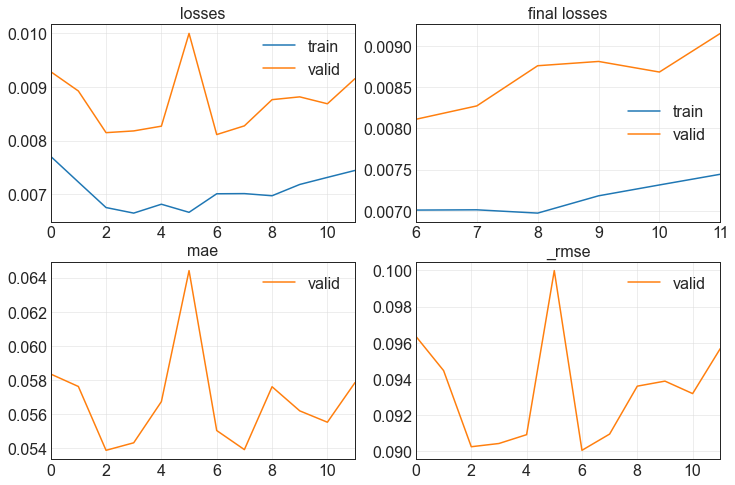

81.58982753753662                                                                                                      
[0.007443703711032867, 0.009154683910310268, 0.057859424501657486, 0.0956801176071167]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 98%|████████████████████████████████████████▏| 98/100 [1:59:29<03:42, 111.35s/trial, best loss: 0.0018984258640557528]

No improvement since epoch 3: early stopping                                                                           
 98%|████████████████████████████████████████▏| 98/100 [2:00:00<03:42, 111.35s/trial, best loss: 0.0018984258640557528]

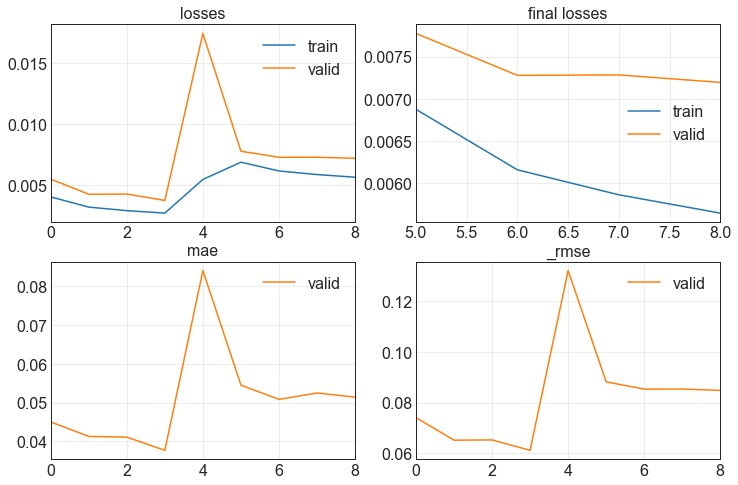

32.09701228141785                                                                                                      
[0.005646765697747469, 0.007194672245532274, 0.051384106278419495, 0.08482140302658081]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}
TST                                                                                                                    
 99%|█████████████████████████████████████████▌| 99/100 [2:00:02<01:27, 87.95s/trial, best loss: 0.0018984258640557528]

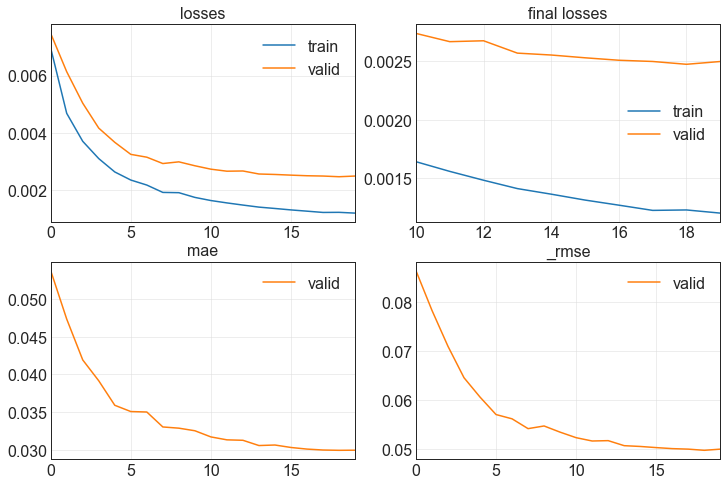

199.23881793022156                                                                                                     
[0.0012041337322443724, 0.002496173372492194, 0.029948532581329346, 0.04996171593666077]                               
100%|█████████████████████████████████████████| 100/100 [2:03:21<00:00, 74.02s/trial, best loss: 0.0018984258640557528]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001E63DEB6438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(7990, 196, 10)

In [62]:
y.shape

(7990, 196)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = TST
k = {
    'n_layers': params['n_layers'],
    'd_model': params['d_model'],
    'n_heads': params['n_heads']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

TST


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): TST(
    (W_P): Linear(in_features=196, out_features=256, bias=True)
    (res_dropout): Dropout(p=0.1, inplace=False)
    (encoder): _TSTEncoder(
      (layers): ModuleList(
        (0): _TSTEncoderLayer(
          (self_attn): _MultiHeadAttention(
            (W_Q): Linear(in_features=256, out_features=256, bias=False)
            (W_K): Linear(in_features=256, out_features=256, bias=False)
            (W_V): Linear(in_features=256, out_features=256, bias=False)
            (W_O): Linear(in_features=256, out_features=256, bias=False)
          )
          (dropout_attn): Dropout(p=0.1, inplace=False)
          (batchnorm_attn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ff): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): GELU()
            (2): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout_ffn): Dropout(p=0.1, inplace=False)
     

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,736,252 total parameters.
1,736,252 training parameters.


Training the model:

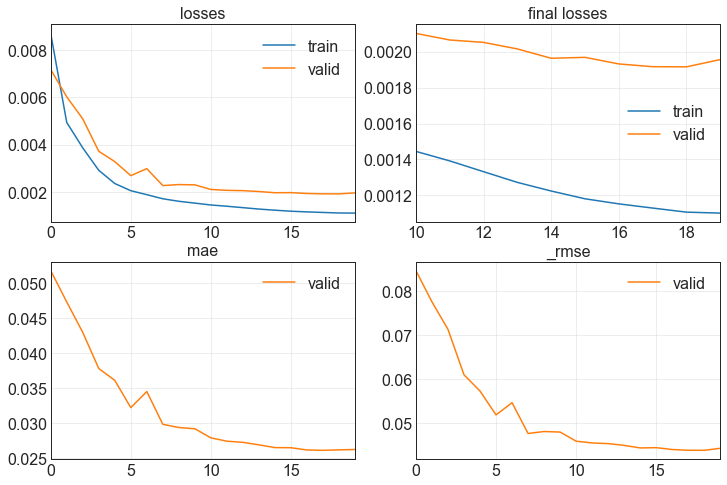

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

1999


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.6535, 0.1882, 0.7680,  ..., 0.4989, 0.0016, 0.0017],
         [0.6653, 0.1920, 0.7581,  ..., 0.5035, 0.0016, 0.0017],
         [0.6264, 0.1985, 0.7413,  ..., 0.4053, 0.0012, 0.0017],
         ...,
         [0.7721, 0.1844, 0.6139,  ..., 0.6673, 0.0015, 0.0012],
         [0.7843, 0.1935, 0.6092,  ..., 0.6636, 0.0012, 0.0010],
         [0.7803, 0.1909, 0.6182,  ..., 0.6586, 0.0011, 0.0009]]),
 tensor([[0.7516, 0.2175, 0.7770,  ..., 0.5197, 0.0000, 0.0000],
         [0.7553, 0.2080, 0.7623,  ..., 0.5126, 0.0000, 0.0000],
         [0.7457, 0.1962, 0.7510,  ..., 0.4877, 0.0000, 0.0000],
         ...,
         [0.7723, 0.1825, 0.6382,  ..., 0.6950, 0.0000, 0.0000],
         [0.7608, 0.1724, 0.6434,  ..., 0.6812, 0.0000, 0.0000],
         [0.7262, 0.1734, 0.6523,  ..., 0.6877, 0.0000, 0.0000]]),
 tensor([[0.6535, 0.1882, 0.7680,  ..., 0.4989, 0.0016, 0.0017],
         [0.6653, 0.1920, 0.7581,  ..., 0.5035, 0.0016, 0.0017],
         [0.6264, 0.1985, 0.7413,  ..., 0.4053, 0.0012, 0.

In [73]:
test_targets.shape

torch.Size([1999, 196])

In [74]:
test_preds.shape

torch.Size([1999, 196])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(1999, 1, 196)

In [78]:
y_pred.shape

(1999, 1, 196)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(1999, 1, 196)

In [83]:
y_pred.shape

(1999, 1, 196)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  69.59786105155945
Test time (in seconds):  0.38109874725341797


In [92]:
print('Training time (in seconds) per epoch: ', 69.59786105155945 / 20)

Training time (in seconds) per epoch:  3.4798930525779723


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  37.777757359983255
MAE:  10.968771829734791


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

TST_TM-minmax_RMSE-10-1-step-1.pdf
TST_TM-minmax_MAE-10-1-step-1.pdf


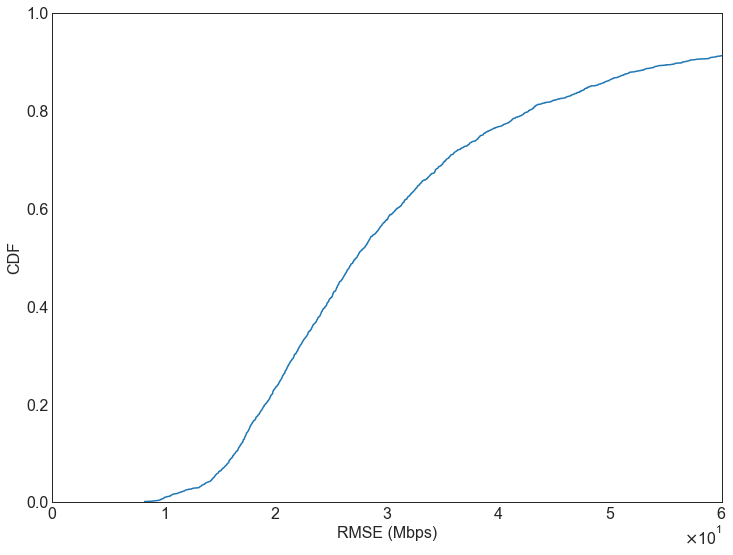

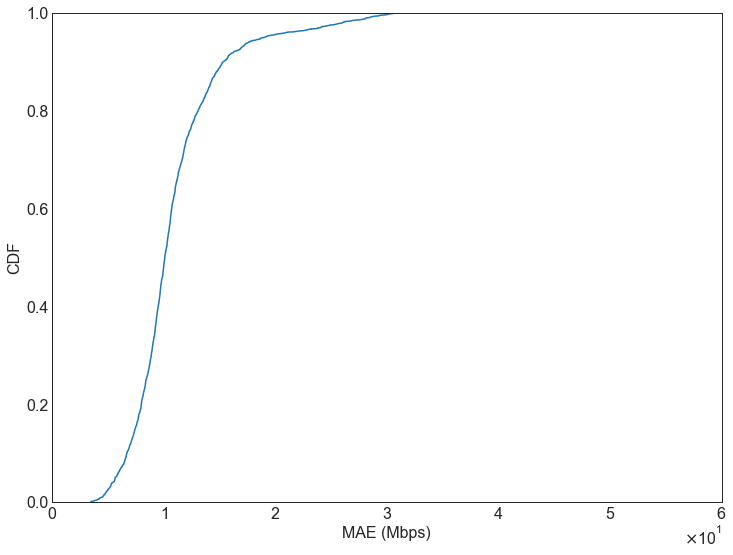

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)